In [1]:
import pandas as pd
import numpy as np
import os
import CRPS.CRPS as pscore
import copy
from joblib import dump, load
from time import sleep
from tqdm import tqdm
import warnings


def check_Actuals(country_id, dataindex):
    # Check if the country_id exists in actual dataset
    if country_id not in country_actual_group_list[dataindex].groups.keys():
        return False
    else:
        return True

# check if the last month of a country in the feature dataset is 3 months before the first month that has to be predicted
def check_last_featureMonth(country_id, dataindex):
    # Check if the country_id exists in actual dataset
    if country_id not in country_actual_group_list[dataindex].groups.keys():
        raise ValueError('country does not have actuals')


    # last month of the feature dataset
    last_feature_month = country_feature_group_list[dataindex].get_group(country_id).index.get_level_values('month_id').unique().tolist()[-1]

    # first month of the actual dataset
    first_actual_month = country_actual_group_list[dataindex].get_group(country_id).index.get_level_values('month_id').unique().tolist()[0]

    # if the last month of the feature dataset in the country does not match the first of the actuals return false
    if (first_actual_month - 3) != last_feature_month:
        return False
    else:
        return True


# create the feature- and actuals-data list
# set the feature and actuals year lists
feature_years = ['2017','2018','2019','2020']
actual_years = ['2018','2019','2020','2021']

actuals_df_list = []
features_df_list = []

# path to the current directory
current_dir = os.getcwd()

for i in range(len(feature_years)):
    # relative paths to the parquet files
    relative_path_features = os.path.join('..', 'data', 'cm_features_to_oct' + feature_years[i] + '.parquet')
    relative_path_actuals = os.path.join('..', 'data', 'cm_actuals_' + actual_years[i] + '.parquet')

    path_features = os.path.join(current_dir, relative_path_features)
    path_actuals = os.path.join(current_dir, relative_path_actuals)

    # append datasets to the lists
    actuals_df_list.append({'year':actual_years[i], 'data':pd.read_parquet(path_actuals, engine='pyarrow')})
    features_df_list.append({'year':feature_years[i], 'data':pd.read_parquet(path_features, engine='pyarrow')})

# concat the feature datasets, so that every data contains the observations starting with january 1990
for i in range(1,len(features_df_list)):
    features_df_list[i]['data'] = pd.concat([features_df_list[i-1]['data'], features_df_list[i]['data']])


from sklearn.feature_selection import VarianceThreshold
from statsmodels.stats.outliers_influence import variance_inflation_factor


data = features_df_list[-1]['data']
if 'gleditsch_ward' in data.columns:
    data = data.drop(columns='gleditsch_ward') # column not necessary

## Features without missing values
columns_without_missing_values = data.columns[data.notna().all()]

for i in range(len(features_df_list)):
    data_set = features_df_list[i]['data']
    features_df_list[i]['data'] = data_set[columns_without_missing_values]

# last dataset contains all other datasets (because of concat) 
all_features = features_df_list[-1]['data'].columns


country_list = sorted(features_df_list[3]['data'].index.get_level_values('country_id').unique().tolist())

# country group list of all four datasets
country_feature_group_list = []
country_actual_group_list = []
# fill list 
for i in range(len(features_df_list)):
    country_feature_group_list.append(features_df_list[i]['data'].groupby('country_id'))
    country_actual_group_list.append(actuals_df_list[i]['data'].groupby('country_id'))

relative_path_countrylist = os.path.join('..', 'data', 'country_list.csv')
path_countrylist = os.path.join(current_dir, relative_path_countrylist)

# CSV-Datei einlesen und als Pandas-Datensatz speichern
countryList_prediction = pd.read_csv(path_countrylist)
country_list_views = countryList_prediction.loc[:,'country_id'].values.tolist() 

month_list = []
countries_to_remove = []
for country_id in country_list:

    if country_id in country_list_views:
        feature_data_views = country_feature_group_list[0].get_group(country_id)

        # numbers of months from the feature dataset
        month_list_feature_data_original = feature_data_views.index.get_level_values('month_id').tolist()
        number_months_feature_data = len(month_list_feature_data_original) 

        # check if actuals exist for the country
        if check_Actuals(country_id, 0):
            # check if the last feature month is 3 months before the first actuals month
            if not check_last_featureMonth(country_id, 0): 
                month_list.append([str(country_id) +' last month missing'])
            else:
                month_list.append([number_months_feature_data, country_id])
        else:
            month_list.append(str(country_id) + ' no actuals')
    else:
        countries_to_remove.append(country_id)

country_list = list(set(country_list) - set(countries_to_remove))
month_list.sort()

# concat all actual month ged_sb for each country
actuals_df_concat = pd.DataFrame()

for i in range(1,len(actuals_df_list)):
    if i == 1:
        actuals_df_concat = pd.concat([actuals_df_list[i-1]['data'], actuals_df_list[i]['data']])
    else:
        actuals_df_concat = pd.concat([actuals_df_concat, actuals_df_list[i]['data']])

actuals_df_concat_group = actuals_df_concat.groupby('country_id')


## Result plots

In [2]:
zero_fatalities_country_list = []
countries_with_low_conflict_list = []
countries_with_middle_conflict_list = []
countries_with_high_conflict_list = []

features_df_concat = features_df_list[3]['data']
features_df_concat_group = features_df_concat.groupby('country_id')

for country_id in country_list:
    feature_data_oct17 = features_df_concat_group.get_group(country_id)

    # Berechnen mittelwert ged_sb in allen testwindows
    mean_fatalities = np.mean(feature_data_oct17['ged_sb'])

    if mean_fatalities == 0:
        zero_fatalities_country_list.append(country_id)
    elif mean_fatalities > 0 and mean_fatalities <= 5:
        countries_with_low_conflict_list.append(country_id)
    elif mean_fatalities > 5 and mean_fatalities <= 100:
        countries_with_middle_conflict_list.append(country_id)
    else:
        countries_with_high_conflict_list.append(country_id)

countries_with_high_conflict_list

[57, 60, 83, 120, 121, 124, 133, 220, 223]

In [3]:
import pandas as pd
from joblib import load
import numpy as np

prediction_data_list = []

for year in actual_years:
    # Pfad zur Parquet-Datei
    parquet_file_path = r'C:\Users\Tobias\Documents\BAconflictPrediction\ConflictPrediction\benchmark views\bm_cm_last_historical_poisson_expanded_' + year + '.parquet'
    # Parquet-Datei in ein DataFrame einlesen
    benchmark_data = pd.read_parquet(parquet_file_path)

    parquet_file_path = r'C:\Users\Tobias\Documents\BAconflictPrediction\ConflictPrediction\plots_model_comp\bodentien_rueter_cm_nbinom_test_window_' + year + '.parquet'
    # Parquet-Datei in ein DataFrame einlesen
    baseline_nbinom_data = pd.read_parquet(parquet_file_path)

    parquet_file_path = r'C:\Users\Tobias\Documents\BAconflictPrediction\ConflictPrediction\plots_model_comp\cm_hurdle_test_window_' + year + '.parquet'
    # Parquet-Datei in ein DataFrame einlesen
    baseline_hurdle_data = pd.read_parquet(parquet_file_path)

    parquet_file_path = r'C:\Users\Tobias\Documents\BAconflictPrediction\ConflictPrediction\plots_model_comp\cm_NeuralNet_test_window_' + year + '.parquet'
    # Parquet-Datei in ein DataFrame einlesen
    nn_data = pd.read_parquet(parquet_file_path)

    parquet_file_path = r'C:\Users\Tobias\Documents\BAconflictPrediction\ConflictPrediction\plots_model_comp\cm_NeuralNetNegBin_test_window_' + year + '.parquet'
    # Parquet-Datei in ein DataFrame einlesen
    nn_negbin_data = pd.read_parquet(parquet_file_path)

    prediction_data_list.append({'benchmark':benchmark_data,
                                 'NB':baseline_nbinom_data,
                                 'Hurdle':baseline_hurdle_data,
                                 'NN':nn_data,
                                 'NNNegBin':nn_negbin_data
                                 })
    
    a = benchmark_data.index.get_level_values('month_id').unique()
    b = baseline_nbinom_data.index.get_level_values('month_id').unique()
    c = baseline_hurdle_data.index.get_level_values('month_id').unique()
    d = nn_data.index.get_level_values('month_id').unique()
    e = nn_negbin_data.index.get_level_values('month_id').unique()

    if not all(a == b):
        print('NB Months falsch year' + str(year))
    elif not all(a == c):
        print('Hurdle months flasch year' + str(year))
    elif not all(a == d):
        print('NN months flasch year' + str(year)) 
    elif not all(a == e):
        print('NN Negbin months flasch year' + str(year))

# Country specific plots
## CDF of three countries

C:\Users\Tobias\AppData\Local\Temp\ipykernel_11016\3574429595.py:18: PerformanceWarning: indexing past lexsort depth may impact performance.
  empirical_distribution_NN = nn_data.loc[(prediction_month,country_to_plot),:].values.flatten()
C:\Users\Tobias\AppData\Local\Temp\ipykernel_11016\3574429595.py:50: PerformanceWarning: indexing past lexsort depth may impact performance.
  empirical_distribution_NBbaseline = baseline_nbinom_data.loc[(prediction_month,country_to_plot),:].values.flatten()
C:\Users\Tobias\AppData\Local\Temp\ipykernel_11016\3574429595.py:82: PerformanceWarning: indexing past lexsort depth may impact performance.
  empirical_distribution_HURDLEbaseline = baseline_hurdle_data.loc[(prediction_month,country_to_plot),:].values.flatten()
C:\Users\Tobias\AppData\Local\Temp\ipykernel_11016\3574429595.py:114: PerformanceWarning: indexing past lexsort depth may impact performance.
  empirical_distribution_NNNegBin = nn_negbin_data.loc[(prediction_month,country_to_plot),:].value

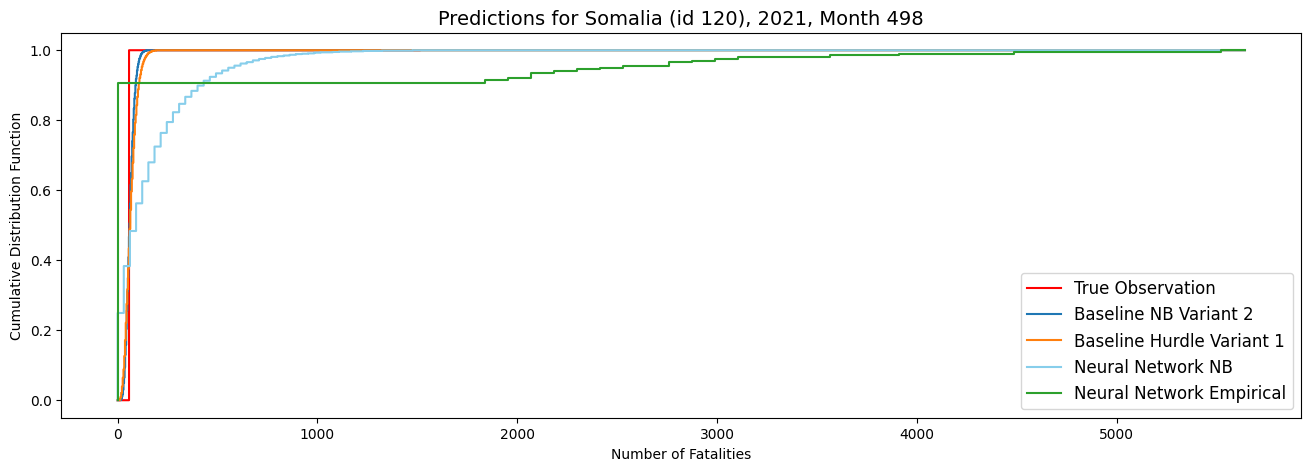

In [4]:
#------------------------------------
prediction_year = '2021' # 2019, 2020, 2021
country_to_plot = 60 # 73 50 120
s = 8 #8
#------------------------------------
dataset_index = actual_years.index(prediction_year)
actual_data = actuals_df_list[dataset_index]['data']
actual_group = actual_data.groupby('country_id')
prediction_month = actual_data.index.get_level_values('month_id').unique().to_list()[s-3]
y_true = actual_group.get_group(country_to_plot).iloc[s-3,0]

import numpy as np
import statsmodels.api as sm # recommended import according to the docs
import matplotlib.pyplot as plt

## neural net empirical-------------------------------------------------------------------------------
nn_data = prediction_data_list[dataset_index]['NN']
empirical_distribution_NN = nn_data.loc[(prediction_month,country_to_plot),:].values.flatten()
empirical_distribution_NN = np.sort(empirical_distribution_NN)

sample = empirical_distribution_NN
ecdf = sm.distributions.ECDF(sample)

x_nn = np.linspace(min(sample), max(sample))
y_nn = ecdf(x_nn)

below_min = np.array(range(0, min(sample)))
x_nn = np.concatenate((below_min, x_nn))
num_zeros = len(below_min)
y_nn = np.concatenate((np.array([0]*num_zeros), y_nn))

## make sure that (0,0) is included
x_nn = np.concatenate((np.array([0]), x_nn))
y_nn = np.concatenate((np.array([0]), y_nn))

if y_true < max(sample):
    max_value = max(sample) + 5
else:
    max_value = int(y_true) + 5

max_for_all = max_value # nn emp has the heaviest tail -> max value for all others

above_max = np.array(range(max(sample)+1, max_value))
x_nn = np.concatenate((x_nn, above_max))
num_ones = len(above_max)
y_nn = np.concatenate((y_nn , np.array([1]*num_ones)))

## baseline negative binomial-----------------------------------------------------------
baseline_nbinom_data = prediction_data_list[dataset_index]['NB']
empirical_distribution_NBbaseline = baseline_nbinom_data.loc[(prediction_month,country_to_plot),:].values.flatten()
empirical_distribution_NBbaseline = np.sort(empirical_distribution_NBbaseline)

sample = empirical_distribution_NBbaseline
ecdf = sm.distributions.ECDF(sample)

x_nb = np.linspace(min(sample), max(sample))
y_nb = ecdf(x_nb)

below_min = np.array(range(0, min(sample)))
x_nb = np.concatenate((below_min, x_nb))
num_zeros = len(below_min)
y_nb = np.concatenate((np.array([0]*num_zeros), y_nb))

## make sure that (0,0) is included
x_nb = np.concatenate((np.array([0]), x_nb))
y_nb = np.concatenate((np.array([0]), y_nb))

""" if y_true < max(sample):
    max_value = max(sample) + 5
else:
    max_value = int(y_true) + 5 """

max_value = max_for_all

above_max = np.array(range(max(sample)+1, max_value))
x_nb = np.concatenate((x_nb, above_max))
num_ones = len(above_max)
y_nb = np.concatenate((y_nb , np.array([1]*num_ones)))

## baseline hurdle----------------------------------------------------------------------------
baseline_hurdle_data = prediction_data_list[dataset_index]['Hurdle']
empirical_distribution_HURDLEbaseline = baseline_hurdle_data.loc[(prediction_month,country_to_plot),:].values.flatten()
empirical_distribution_HURDLEbaseline = np.sort(empirical_distribution_HURDLEbaseline)

sample = empirical_distribution_HURDLEbaseline
ecdf = sm.distributions.ECDF(sample)

x_hurdle = np.linspace(min(sample), max(sample))
y_hurdle = ecdf(x_hurdle)

below_min = np.array(range(0, min(sample)))
x_hurdle = np.concatenate((below_min, x_hurdle))
num_zeros = len(below_min)
y_hurdle = np.concatenate((np.array([0]*num_zeros), y_hurdle))

## make sure that (0,0) is included
x_hurdle = np.concatenate((np.array([0]), x_hurdle))
y_hurdle = np.concatenate((np.array([0]), y_hurdle))

""" if y_true < max(sample):
    max_value = max(sample) + 5
else:
    max_value = int(y_true) + 5 """

max_value = max_for_all

above_max = np.array(range(max(sample)+1, max_value))
x_hurdle = np.concatenate((x_hurdle, above_max))
num_ones = len(above_max)
y_hurdle = np.concatenate((y_hurdle , np.array([1]*num_ones)))

## neural net negative binomial-----------------------------------------------------------------------
nn_negbin_data = prediction_data_list[dataset_index]['NNNegBin']
empirical_distribution_NNNegBin = nn_negbin_data.loc[(prediction_month,country_to_plot),:].values.flatten()
empirical_distribution_NNNegBin = np.sort(empirical_distribution_NNNegBin)

sample = empirical_distribution_NNNegBin
ecdf = sm.distributions.ECDF(sample)

x_nn_negbin = np.linspace(min(sample), max(sample))
y_nn_negbin = ecdf(x_nn_negbin)

below_min = np.array(range(0, min(sample)))
x_nn_negbin = np.concatenate((below_min, x_nn_negbin))
num_zeros = len(below_min)
y_nn_negbin = np.concatenate((np.array([0]*num_zeros), y_nn_negbin))

## make sure that (0,0) is included
x_nn_negbin = np.concatenate((np.array([0]), x_nn_negbin))
y_nn_negbin = np.concatenate((np.array([0]), y_nn_negbin))

""" if y_true < max(sample):
    max_value = max(sample) + 5
else:
    max_value = int(y_true) + 5 """

max_value = max_for_all

above_max = np.array(range(max(sample)+1, max_value))
x_nn_negbin = np.concatenate((x_nn_negbin, above_max))
num_ones = len(above_max)
y_nn_negbin = np.concatenate((y_nn_negbin , np.array([1]*num_ones)))

## acutal distribution------------------------------------------------------------
sample_true = int(y_true)
x_acutal = np.array([y_true])
y_acutal = np.array([1])

below_min = np.array(range(0, sample_true))
x_acutal = np.concatenate((below_min, x_acutal))
num_zeros = len(below_min)
y_acutal = np.concatenate((np.array([0]*num_zeros), y_acutal))

## make sure that (0,0) is included
x_acutal = np.concatenate((np.array([0]), x_acutal))
y_acutal = np.concatenate((np.array([0]), y_acutal))

if y_true < max(sample):
    max_value = max(sample) + 5
else:
    max_value = int(y_true) + 5
above_max = np.array(range(sample_true+1, max_value))
x_acutal = np.concatenate((x_acutal, above_max))
num_ones = len(above_max)
y_acutal = np.concatenate((y_acutal , np.array([1]*num_ones)))

plt.figure(figsize=(16, 5))

plt.step(x_acutal, y_acutal, color='red')
plt.step(x_nb, y_nb)
plt.step(x_hurdle, y_hurdle)
plt.step(x_nn_negbin, y_nn_negbin, color='skyblue')
plt.step(x_nn, y_nn)
plt.xlabel('Number of Fatalities')
plt.ylabel('Cumulative Distribution Function')
#plt.title('Predictions for Tunisia (id 73), 2021, month ' + str(prediction_month), fontsize=14, y=1)
#plt.title('Predictions for Mali (id 50), 2021, month ' + str(prediction_month), fontsize=14, y=1)
plt.title('Predictions for Somalia (id 120), 2021, Month ' + str(prediction_month), fontsize=14, y=1)
plt.legend(loc='lower right', labels=['True Observation', 'Baseline NB Variant 2', 'Baseline Hurdle Variant 1', 'Neural Network NB', 'Neural Network Empirical'], fontsize=12)
plt.show()

## Actuals vs. predictive distribution

C:\Users\Tobias\AppData\Local\Temp\ipykernel_11016\4289517159.py:27: PerformanceWarning: indexing past lexsort depth may impact performance.
  empirical_distribution = model_data.loc[(prediction_month,country_to_plot),:].values.flatten()


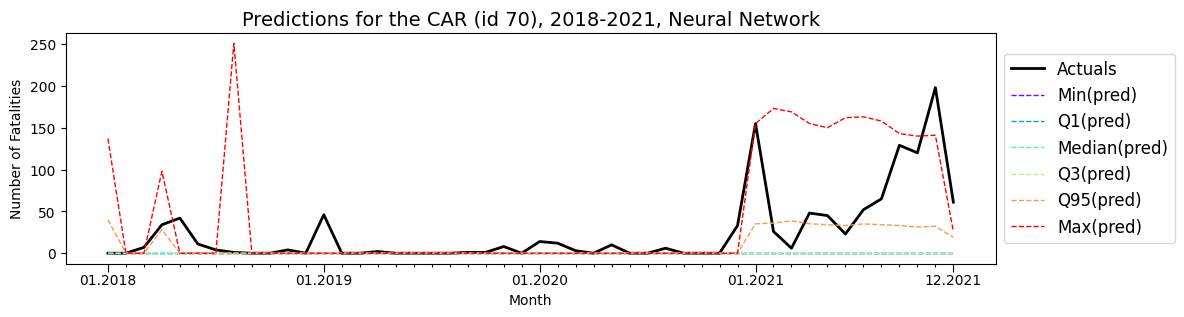

In [5]:
#------------------------------------
country_to_plot = 70 #133!! 57 124 133 126
method = 'NN'  # benchmark  NB  Hurdle  NN  NNNegBin
#------------------------------------
s_prediction_list = list(range(3, 15))

month_list_plot = []
actual_list = []
min_list = []
quant_025_list = []
quant_050_list = []
quant_075_list = []
quant_095_list = []
max_list = []

for year in actual_years:    
    dataset_index = actual_years.index(year)

    model_data = prediction_data_list[dataset_index][method]

    actual_data = actuals_df_list[dataset_index]['data']
    actual_group = actual_data.groupby('country_id')

    for s in s_prediction_list:
        
        prediction_month = actual_data.index.get_level_values('month_id').unique().to_list()[s-3]
        empirical_distribution = model_data.loc[(prediction_month,country_to_plot),:].values.flatten()

        month_list_plot.append(prediction_month)
        actual_list.append(actual_group.get_group(country_to_plot).iloc[s-3,0])
        min_list.append(min(empirical_distribution))
        quant_025_list.append(np.percentile(empirical_distribution, 25))
        quant_050_list.append(np.percentile(empirical_distribution, 50))
        quant_075_list.append(np.percentile(empirical_distribution, 75))
        quant_095_list.append(np.percentile(empirical_distribution, 95))
        max_list.append(max(empirical_distribution))


import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import numpy as np

# Beispielwerte für Actuals und Quantile
months = month_list_plot
actuals = actual_list
minimum = min_list
quantile_25 = quant_025_list
quantile_50 = quant_050_list
quantile_75 = quant_075_list
quantile_95 = quant_095_list
maximum = max_list

plt.figure(figsize=(12, 3))

# Erzeuge das Liniendiagramm
plt.plot(months, actuals, color='black', linewidth=2, label='Actuals')
plt.plot(months, minimum, color=plt.cm.rainbow(0),linewidth=1, linestyle='--', label='Min(pred)')
plt.plot(months, quantile_25, color=plt.cm.rainbow(0.2),linewidth=1, linestyle='--', label='Q1(pred)')
plt.plot(months, quantile_50, color=plt.cm.rainbow(0.4),linewidth=1, linestyle='--', label='Median(pred)')
plt.plot(months, quantile_75, color=plt.cm.rainbow(0.6),linewidth=1, linestyle='--', label='Q3(pred)')
plt.plot(months, quantile_95, color=plt.cm.rainbow(0.8),linewidth=1, linestyle='--', label='Q95(pred)')
plt.plot(months, maximum, color=plt.cm.rainbow(1.0),linewidth=1, linestyle='--', label='Max(pred)')

custom_ticks = months
custom_labels = []
january = ['01.2018','01.2019','01.2020','01.2021','12.2021']
january_list = [0,12,24,36,47]
j = 0
for i in range(len(months)):
    if i in january_list: 
        custom_labels.append(january[j])
        j += 1
    else:
        custom_labels.append('')

plt.xticks(custom_ticks, custom_labels)

# Mache bestimmte Ticks dicker
for i, tick in enumerate(plt.gca().xaxis.get_major_ticks()):
    if i in january_list:
        #tick.label1.set_fontsize(14)  # Setze die Dicke der gewünschten Ticks
        tick.tick1line.set_markersize(6)  # Ändert die Länge der Ticks
        tick.label1.set_verticalalignment('top')
    else:
        tick.tick1line.set_markersize(2) 

plt.xlabel('Month')
plt.ylabel('Number of Fatalities')
#plt.title('Predictions for Afghanistan (id 133), 2018-2021, Hurdle', fontsize=14, y=1) # Benchmark  NB   Hurdle   Neural Net
plt.title('Predictions for the CAR (id 70), 2018-2021, Neural Network', fontsize=14, y=1) # Benchmark  NB   Hurdle   Neural Net
#plt.title(str(country_to_plot), fontsize=14, y=1) # Benchmark  NB   Hurdle   Neural Net
# Fasse die Quantile zu einem Eintrag in der Legende zusammen und platziere sie rechts
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=12)

# Zeige das Diagramm
plt.show()

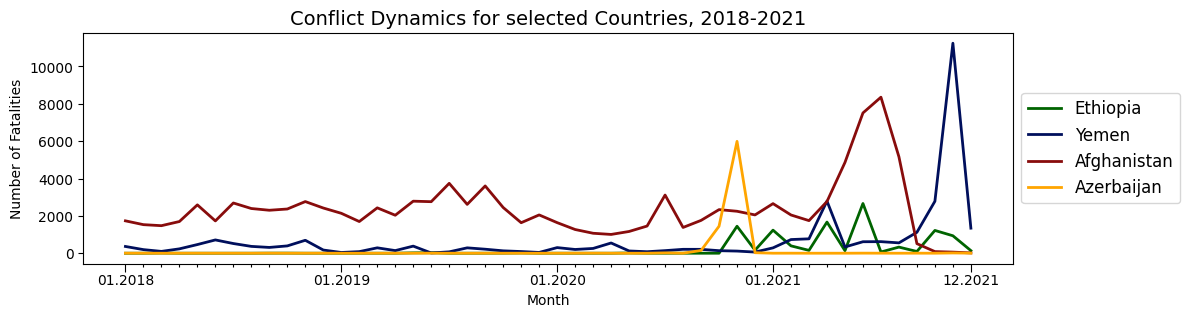

In [6]:
#------------------------------------
country_to_plot_57 = 57
country_to_plot_124 = 124
country_to_plot_133 = 133
country_to_plot_126 = 126
#------------------------------------
s_prediction_list = list(range(3, 15))

month_list_plot = []
actual_list_afghan = []
actual_list_ethiopia = []
actual_list_yemen = []
actual_list_Azerbaijan = []

for year in actual_years:  
    dataset_index = actual_years.index(year)

    actual_data = actuals_df_list[dataset_index]['data']
    actual_group = actual_data.groupby('country_id')

    for s in s_prediction_list:
        
        prediction_month = actual_data.index.get_level_values('month_id').unique().to_list()[s-3]

        month_list_plot.append(prediction_month)
        actual_list_ethiopia.append(actual_group.get_group(country_to_plot_57).iloc[s-3,0])
        actual_list_yemen.append(actual_group.get_group(country_to_plot_124).iloc[s-3,0])
        actual_list_afghan.append(actual_group.get_group(country_to_plot_133).iloc[s-3,0])
        actual_list_Azerbaijan.append(actual_group.get_group(country_to_plot_126).iloc[s-3,0])


import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import numpy as np

# Beispielwerte für Actuals und Quantile
months = month_list_plot
actuals_ethiopia = actual_list_ethiopia
actuals_yemen = actual_list_yemen
actuals_afghan = actual_list_afghan
actuals_azer = actual_list_Azerbaijan

plt.figure(figsize=(12, 3))

# Erzeuge das Liniendiagramm
plt.plot(months, actuals_ethiopia, color='darkgreen', linewidth=2, label='Ethiopia')
plt.plot(months, actuals_yemen, color='#000f5c',linewidth=2, label='Yemen')
plt.plot(months, actuals_afghan, color='#880c0c',linewidth=2, label='Afghanistan')
plt.plot(months, actuals_azer, color='orange',linewidth=2, label='Azerbaijan')

custom_ticks = months
custom_labels = []
january = ['01.2018','01.2019','01.2020','01.2021','12.2021']
january_list = [0,12,24,36,47]
j = 0
for i in range(len(months)):
    if i in january_list: 
        custom_labels.append(january[j])
        j += 1
    else:
        custom_labels.append('')

plt.xticks(custom_ticks, custom_labels)

# Mache bestimmte Ticks dicker
for i, tick in enumerate(plt.gca().xaxis.get_major_ticks()):
    if i in january_list:
        #tick.label1.set_fontsize(14)  # Setze die Dicke der gewünschten Ticks
        tick.tick1line.set_markersize(6)  # Ändert die Länge der Ticks
        tick.label1.set_verticalalignment('top')
    else:
        tick.tick1line.set_markersize(2) 

plt.xlabel('Month')
plt.ylabel('Number of Fatalities')
#plt.title('Predictions for Afghanistan (id 133), 2018-2021, Benchmark', fontsize=14, y=1) # Benchmark  NB   Hurdle   Neural Net
plt.title('Conflict Dynamics for selected Countries, 2018-2021', fontsize=14, y=1) # Benchmark  NB   Hurdle   Neural Net
# Fasse die Quantile zu einem Eintrag in der Legende zusammen und platziere sie rechts
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=12)

# Zeige das Diagramm
plt.show()

In [7]:
dict_middle = {'country':[], 'fatal':[]}

for country in countries_with_middle_conflict_list:
    dataset_index = actual_years.index('2020')

    actual_data = actuals_df_list[dataset_index]['data']
    actual_group = actual_data.groupby('country_id')

    dict_middle['country'].append(country)
    dict_middle['fatal'].append(actual_group.get_group(country).iloc[10,0])

In [8]:
dict_middle['fatal'].index(max(dict_middle['fatal']))

15

In [9]:
dict_middle['country'][15]

126

# CRPS over all countries

In [10]:
import CRPS.CRPS as pscore

s_prediction_list = list(range(3, 15))

month_list_plot = []
crps_last_poisson = []
crps_nb_baseline = []
crps_hurdle_baseline = []
crps_nn = []
crps_nn_negbin = []

for year in actual_years:    
    dataset_index = actual_years.index(year)

    last_poisson_data = prediction_data_list[dataset_index]['benchmark']
    nb_baseline_data = prediction_data_list[dataset_index]['NB']
    hurdle_baseline_data = prediction_data_list[dataset_index]['Hurdle']
    nn_data = prediction_data_list[dataset_index]['NN']
    nn_negbin_data = prediction_data_list[dataset_index]['NNNegBin']

    actual_data = actuals_df_list[dataset_index]['data']
    actual_group = actual_data.groupby('country_id')

    for s in s_prediction_list:
        
        mean_crps_last_poisson = []
        mean_crps_nb_baseline = []
        mean_crps_hurdle_baseline = []
        mean_crps_nn_empirical = []
        mean_crps_nn_negbin = []

        for country in country_list:

            prediction_month = actual_data.index.get_level_values('month_id').unique().to_list()[s-3]
            y_true = actual_group.get_group(country).iloc[s-3,0]
            
            last_poisson_empirical_distribution = last_poisson_data.loc[(prediction_month,country),:].values.flatten()
            nb_baseline_empirical_distribution = nb_baseline_data.loc[(prediction_month,country),:].values.flatten()
            hurdle_baseline_empirical_distribution = hurdle_baseline_data.loc[(prediction_month,country),:].values.flatten()
            nn_empirical_distribution = nn_data.loc[(prediction_month,country),:].values.flatten()
            nn_negbin_empirical_distribution = nn_negbin_data.loc[(prediction_month,country),:].values.flatten()

            mean_crps_last_poisson.append(pscore(last_poisson_empirical_distribution,y_true).compute()[0])
            mean_crps_nb_baseline.append(pscore(nb_baseline_empirical_distribution,y_true).compute()[0])
            mean_crps_hurdle_baseline.append(pscore(hurdle_baseline_empirical_distribution,y_true).compute()[0])
            mean_crps_nn_empirical.append(pscore(nn_empirical_distribution,y_true).compute()[0])
            mean_crps_nn_negbin.append(pscore(nn_negbin_empirical_distribution,y_true).compute()[0])

        month_list_plot.append(prediction_month)
        crps_last_poisson.append(np.mean(mean_crps_last_poisson))
        crps_nb_baseline.append(np.mean(mean_crps_nb_baseline))
        crps_hurdle_baseline.append(np.mean(mean_crps_hurdle_baseline))
        crps_nn.append(np.mean(mean_crps_nn_empirical))
        crps_nn_negbin.append(np.mean(mean_crps_nn_negbin))

C:\Users\Tobias\AppData\Local\Temp\ipykernel_11016\2509366716.py:38: PerformanceWarning: indexing past lexsort depth may impact performance.
  nb_baseline_empirical_distribution = nb_baseline_data.loc[(prediction_month,country),:].values.flatten()
C:\Users\Tobias\AppData\Local\Temp\ipykernel_11016\2509366716.py:39: PerformanceWarning: indexing past lexsort depth may impact performance.
  hurdle_baseline_empirical_distribution = hurdle_baseline_data.loc[(prediction_month,country),:].values.flatten()
C:\Users\Tobias\AppData\Local\Temp\ipykernel_11016\2509366716.py:40: PerformanceWarning: indexing past lexsort depth may impact performance.
  nn_empirical_distribution = nn_data.loc[(prediction_month,country),:].values.flatten()
C:\Users\Tobias\AppData\Local\Temp\ipykernel_11016\2509366716.py:41: PerformanceWarning: indexing past lexsort depth may impact performance.
  nn_negbin_empirical_distribution = nn_negbin_data.loc[(prediction_month,country),:].values.flatten()


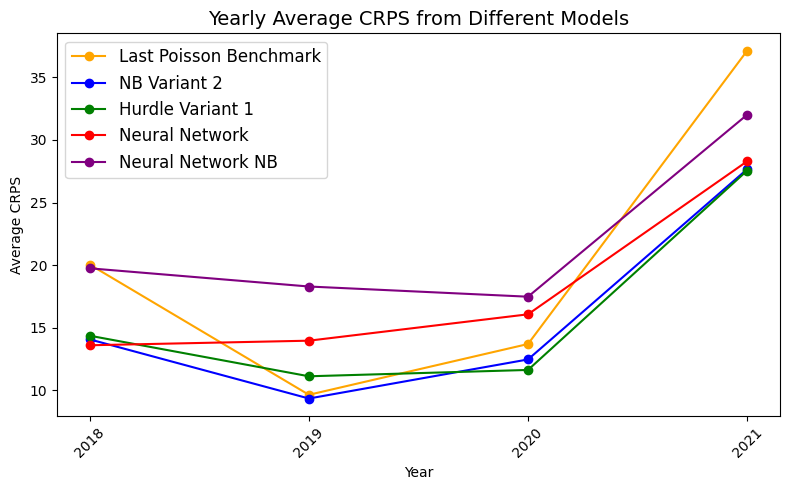

In [11]:
crps_by_year = {
    '2018': [],
    '2019': [],
    '2020': [],
    '2021': []
}

Keys_crps_by_year = list(crps_by_year.keys())
index_list = [[0,12], [12,24], [24,36], [36,48]]

for i in range(len(crps_by_year)):
    crps_by_year[Keys_crps_by_year[i]].append(np.mean(crps_last_poisson[index_list[i][0]:index_list[i][1]]))
    crps_by_year[Keys_crps_by_year[i]].append(np.mean(crps_nb_baseline[index_list[i][0]:index_list[i][1]]))
    crps_by_year[Keys_crps_by_year[i]].append(np.mean(crps_hurdle_baseline[index_list[i][0]:index_list[i][1]]))
    crps_by_year[Keys_crps_by_year[i]].append(np.mean(crps_nn[index_list[i][0]:index_list[i][1]]))
    crps_by_year[Keys_crps_by_year[i]].append(np.mean(crps_nn_negbin[index_list[i][0]:index_list[i][1]]))

import matplotlib.pyplot as plt

# Daten
methoden = [
    'Last Poisson Benchmark',
    'NB Variant 2',
    'Hurdle Variant 1',
    'Neural Network',
    'Neural Network NB'
]

# Plot erstellen
plt.figure(figsize=(8, 5))

colors = ['orange','blue','green','red','purple']

# Für jede Methode eine Linie zeichnen
for i, methode in enumerate(methoden):
    plt.plot(crps_by_year.keys(), [crps_by_year[jahr][i] for jahr in crps_by_year.keys()], marker='o', label=methode, color=colors[i])

# Titel und Achsenbeschriftungen
plt.title('Yearly Average CRPS from Different Models', fontsize=14)
plt.xlabel('Year')
plt.ylabel('Average CRPS')

# Legende hinzufügen
plt.legend(fontsize=12, loc='upper left') #loc='center left', bbox_to_anchor=(1, 0.5)

# Diagramm anzeigen
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [12]:
crps_by_year['2021']

[37.12925334598604,
 27.661083008861414,
 27.552442800435557,
 28.29612555628273,
 32.014839030149716]

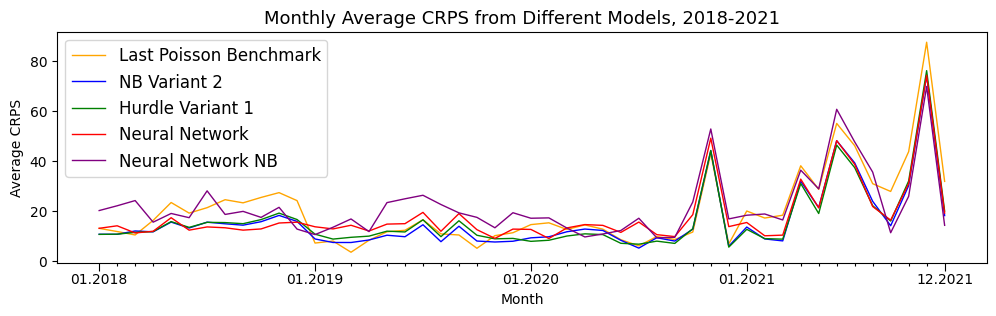

In [13]:
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import numpy as np


months = month_list_plot
last_poisson = crps_last_poisson
nb_baseline = crps_nb_baseline
hurdle_baseline = crps_hurdle_baseline
nn = crps_nn
nn_negbin = crps_nn_negbin

plt.figure(figsize=(12, 3))

# Erzeuge das Liniendiagramm
plt.plot(months, last_poisson, color='orange', linewidth=1, label='Last Poisson Benchmark')
plt.plot(months, nb_baseline, color='blue', linewidth=1, label='NB Variant 2')
plt.plot(months, hurdle_baseline, color='green', linewidth=1, label='Hurdle Variant 1')
plt.plot(months, nn, linewidth=1, color='red', label='Neural Network')
plt.plot(months, nn_negbin, linewidth=1, color='purple', label='Neural Network NB')

custom_ticks = months
custom_labels = []
january = ['01.2018','01.2019','01.2020','01.2021','12.2021']
january_list = [0,12,24,36,47]
j = 0
for i in range(len(months)):
    if i in january_list: 
        custom_labels.append(january[j])
        j += 1
    else:
        custom_labels.append('')

plt.xticks(custom_ticks, custom_labels)

# Mache bestimmte Ticks dicker
for i, tick in enumerate(plt.gca().xaxis.get_major_ticks()):
    if i in january_list:
        #tick.label1.set_fontsize(14)  # Setze die Dicke der gewünschten Ticks
        tick.tick1line.set_markersize(6)  # Ändert die Länge der Ticks
        tick.label1.set_verticalalignment('top')
    else:
        tick.tick1line.set_markersize(2) 

plt.title('Monthly Average CRPS from Different Models, 2018-2021', fontsize=13, y=1)
plt.xlabel('Month')
plt.ylabel('Average CRPS')

# Fasse die Quantile zu einem Eintrag in der Legende zusammen und platziere sie rechts
#plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.legend(fontsize=12, loc='upper left')

# Zeige das Diagramm
plt.show()

## Check correlation of sum of crps 2018-21 vs. sum of fatalities Ethiopia, Yemen, Afghanistan, Azerbajian

In [14]:
actuals_sum_ethio_yem_afghan_azerbaj = [sum(x) for x in zip(actuals_ethiopia, actuals_yemen, actuals_afghan, actuals_azer)]
crps_sum_mymodels = [sum(x) for x in zip(nb_baseline, hurdle_baseline, nn, nn_negbin)]

np.corrcoef(actuals_sum_ethio_yem_afghan_azerbaj, crps_sum_mymodels)[0, 1]

0.9481918543480147

In [15]:
variables_matrix = np.array([actuals_sum_ethio_yem_afghan_azerbaj, nb_baseline, hurdle_baseline, nn, nn_negbin])

# Berechne die Korrelationsmatrix
correlation_matrix = np.corrcoef(variables_matrix)
correlation_matrix

array([[1.        , 0.91785356, 0.91055206, 0.93091873, 0.95429231],
       [0.91785356, 1.        , 0.9940649 , 0.97382875, 0.90931916],
       [0.91055206, 0.9940649 , 1.        , 0.97721648, 0.90342261],
       [0.93091873, 0.97382875, 0.97721648, 1.        , 0.9131539 ],
       [0.95429231, 0.90931916, 0.90342261, 0.9131539 , 1.        ]])

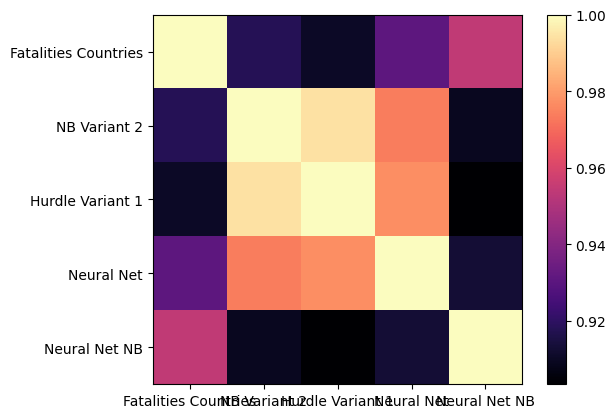

In [16]:
plt.imshow(correlation_matrix, cmap='magma', interpolation='nearest')
plt.colorbar()

# Setze die Beschriftungen der Achsen
plt.xticks(np.arange(5), ['Fatalities Countries', 'NB Variant 2', 'Hurdle Variant 1', 'Neural Net', 'Neural Net NB'])
plt.yticks(np.arange(5), ['Fatalities Countries', 'NB Variant 2', 'Hurdle Variant 1', 'Neural Net', 'Neural Net NB'])

plt.show()

# CRPS over different levels of conflicts

In [17]:
import CRPS.CRPS as pscore

s_prediction_list = list(range(3, 15))

month_list_plot = []

crps_last_poisson_low = []
crps_nb_baseline_low = []
crps_hurdle_baseline_low = []
crps_nn_low = []
crps_nn_negbin_low = []

crps_last_poisson_middle = []
crps_nb_baseline_middle = []
crps_hurdle_baseline_middle = []
crps_nn_middle = []
crps_nn_negbin_middle = []

crps_last_poisson_high = []
crps_nb_baseline_high = []
crps_hurdle_baseline_high = []
crps_nn_high = []
crps_nn_negbin_high = []

for year in actual_years:    
    dataset_index = actual_years.index(year)

    last_poisson_data = prediction_data_list[dataset_index]['benchmark']
    nb_baseline_data = prediction_data_list[dataset_index]['NB']
    hurdle_baseline_data = prediction_data_list[dataset_index]['Hurdle']
    nn_data = prediction_data_list[dataset_index]['NN']
    nn_negbin_data = prediction_data_list[dataset_index]['NNNegBin']

    actual_data = actuals_df_list[dataset_index]['data']
    actual_group = actual_data.groupby('country_id')

    for s in s_prediction_list:
        
        mean_crps_last_poisson_low = []
        mean_crps_nb_baseline_low = []
        mean_crps_hurdle_baseline_low = []
        mean_crps_nn_empirical_low = []
        mean_crps_nn_negbin_low = []

        mean_crps_last_poisson_middle = []
        mean_crps_nb_baseline_middle = []
        mean_crps_hurdle_baseline_middle = []
        mean_crps_nn_empirical_middle = []
        mean_crps_nn_negbin_middle = []

        mean_crps_last_poisson_high = []
        mean_crps_nb_baseline_high = []
        mean_crps_hurdle_baseline_high = []
        mean_crps_nn_empirical_high = []
        mean_crps_nn_negbin_high = []

        for country in country_list:

            prediction_month = actual_data.index.get_level_values('month_id').unique().to_list()[s-3]
            y_true = actual_group.get_group(country).iloc[s-3,0]
            
            last_poisson_empirical_distribution = last_poisson_data.loc[(prediction_month,country),:].values.flatten()
            nb_baseline_empirical_distribution = nb_baseline_data.loc[(prediction_month,country),:].values.flatten()
            hurdle_baseline_empirical_distribution = hurdle_baseline_data.loc[(prediction_month,country),:].values.flatten()
            nn_empirical_distribution = nn_data.loc[(prediction_month,country),:].values.flatten()
            nn_negbin_empirical_distribution = nn_negbin_data.loc[(prediction_month,country),:].values.flatten()


            if country in countries_with_low_conflict_list:
                mean_crps_last_poisson_low.append(pscore(last_poisson_empirical_distribution,y_true).compute()[0])
                mean_crps_nb_baseline_low.append(pscore(nb_baseline_empirical_distribution,y_true).compute()[0])
                mean_crps_hurdle_baseline_low.append(pscore(hurdle_baseline_empirical_distribution,y_true).compute()[0])
                mean_crps_nn_empirical_low.append(pscore(nn_empirical_distribution,y_true).compute()[0])
                mean_crps_nn_negbin_low.append(pscore(nn_negbin_empirical_distribution,y_true).compute()[0])

            elif country in countries_with_middle_conflict_list:
                mean_crps_last_poisson_middle.append(pscore(last_poisson_empirical_distribution,y_true).compute()[0])
                mean_crps_nb_baseline_middle.append(pscore(nb_baseline_empirical_distribution,y_true).compute()[0])
                mean_crps_hurdle_baseline_middle.append(pscore(hurdle_baseline_empirical_distribution,y_true).compute()[0])
                mean_crps_nn_empirical_middle.append(pscore(nn_empirical_distribution,y_true).compute()[0])
                mean_crps_nn_negbin_middle.append(pscore(nn_negbin_empirical_distribution,y_true).compute()[0])

            elif country in countries_with_high_conflict_list:
                mean_crps_last_poisson_high.append(pscore(last_poisson_empirical_distribution,y_true).compute()[0])
                mean_crps_nb_baseline_high.append(pscore(nb_baseline_empirical_distribution,y_true).compute()[0])
                mean_crps_hurdle_baseline_high.append(pscore(hurdle_baseline_empirical_distribution,y_true).compute()[0])
                mean_crps_nn_empirical_high.append(pscore(nn_empirical_distribution,y_true).compute()[0])
                mean_crps_nn_negbin_high.append(pscore(nn_negbin_empirical_distribution,y_true).compute()[0])

        month_list_plot.append(prediction_month)

        crps_last_poisson_low.append(np.mean(mean_crps_last_poisson_low))
        crps_nb_baseline_low.append(np.mean(mean_crps_nb_baseline_low))
        crps_hurdle_baseline_low.append(np.mean(mean_crps_hurdle_baseline_low))
        crps_nn_low.append(np.mean(mean_crps_nn_empirical_low))
        crps_nn_negbin_low.append(np.mean(mean_crps_nn_negbin_low))

        crps_last_poisson_middle.append(np.mean(mean_crps_last_poisson_middle))
        crps_nb_baseline_middle.append(np.mean(mean_crps_nb_baseline_middle))
        crps_hurdle_baseline_middle.append(np.mean(mean_crps_hurdle_baseline_middle))
        crps_nn_middle.append(np.mean(mean_crps_nn_empirical_middle))
        crps_nn_negbin_middle.append(np.mean(mean_crps_nn_negbin_middle))

        crps_last_poisson_high.append(np.mean(mean_crps_last_poisson_high))
        crps_nb_baseline_high.append(np.mean(mean_crps_nb_baseline_high))
        crps_hurdle_baseline_high.append(np.mean(mean_crps_hurdle_baseline_high))
        crps_nn_high.append(np.mean(mean_crps_nn_empirical_high))
        crps_nn_negbin_high.append(np.mean(mean_crps_nn_negbin_high))

C:\Users\Tobias\AppData\Local\Temp\ipykernel_11016\1646102157.py:63: PerformanceWarning: indexing past lexsort depth may impact performance.
  nb_baseline_empirical_distribution = nb_baseline_data.loc[(prediction_month,country),:].values.flatten()
C:\Users\Tobias\AppData\Local\Temp\ipykernel_11016\1646102157.py:64: PerformanceWarning: indexing past lexsort depth may impact performance.
  hurdle_baseline_empirical_distribution = hurdle_baseline_data.loc[(prediction_month,country),:].values.flatten()
C:\Users\Tobias\AppData\Local\Temp\ipykernel_11016\1646102157.py:65: PerformanceWarning: indexing past lexsort depth may impact performance.
  nn_empirical_distribution = nn_data.loc[(prediction_month,country),:].values.flatten()
C:\Users\Tobias\AppData\Local\Temp\ipykernel_11016\1646102157.py:66: PerformanceWarning: indexing past lexsort depth may impact performance.
  nn_negbin_empirical_distribution = nn_negbin_data.loc[(prediction_month,country),:].values.flatten()


In [18]:
len(countries_with_low_conflict_list) + len(countries_with_middle_conflict_list) + len(countries_with_high_conflict_list) + len(zero_fatalities_country_list)

191

In [19]:
crps_conflict_level = {'low':{'pois':crps_last_poisson_low, 
                              'NB':crps_nb_baseline_low, 
                              'Hurdle':crps_hurdle_baseline_low, 
                              'NN':crps_nn_low, 
                              'NN_NegBin':crps_nn_negbin_low},
                        'middle':{'pois':crps_last_poisson_middle, 
                              'NB':crps_nb_baseline_middle, 
                              'Hurdle':crps_hurdle_baseline_middle, 
                              'NN':crps_nn_middle, 
                              'NN_NegBin':crps_nn_negbin_middle},
                        'high':{'pois':crps_last_poisson_high, 
                              'NB':crps_nb_baseline_high, 
                              'Hurdle':crps_hurdle_baseline_high, 
                              'NN':crps_nn_high, 
                              'NN_NegBin':crps_nn_negbin_high},
                              }

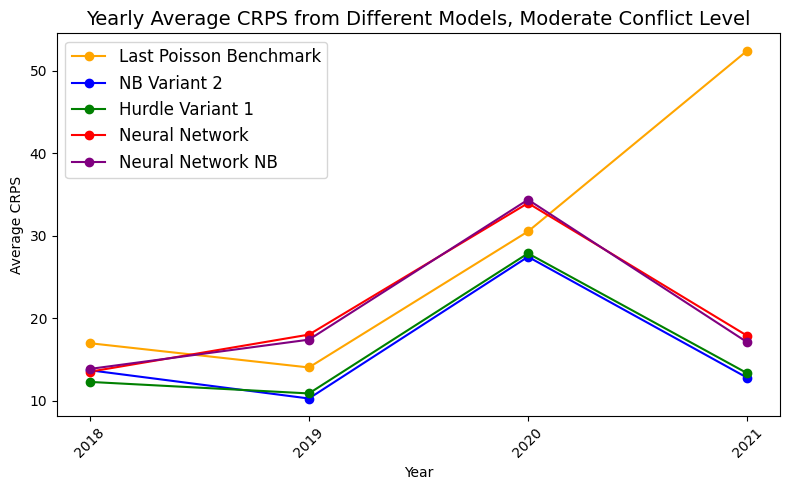

In [20]:
conflict_level = 'middle'

crps_by_year = {
    '2018': [],
    '2019': [],
    '2020': [],
    '2021': []
}

Keys_crps_by_year = list(crps_by_year.keys())
index_list = [[0,12], [12,24], [24,36], [36,48]]

for i in range(len(crps_by_year)):
    crps_by_year[Keys_crps_by_year[i]].append(np.mean(crps_conflict_level[conflict_level]['pois'][index_list[i][0]:index_list[i][1]]))
    crps_by_year[Keys_crps_by_year[i]].append(np.mean(crps_conflict_level[conflict_level]['NB'][index_list[i][0]:index_list[i][1]]))
    crps_by_year[Keys_crps_by_year[i]].append(np.mean(crps_conflict_level[conflict_level]['Hurdle'][index_list[i][0]:index_list[i][1]]))
    crps_by_year[Keys_crps_by_year[i]].append(np.mean(crps_conflict_level[conflict_level]['NN'][index_list[i][0]:index_list[i][1]]))
    crps_by_year[Keys_crps_by_year[i]].append(np.mean(crps_conflict_level[conflict_level]['NN_NegBin'][index_list[i][0]:index_list[i][1]]))

import matplotlib.pyplot as plt

# Daten
methoden = [
    'Last Poisson Benchmark',
    'NB Variant 2',
    'Hurdle Variant 1',
    'Neural Network',
    'Neural Network NB'
]

# Plot erstellen
plt.figure(figsize=(8, 5))

colors = ['orange','blue','green','red','purple']

# Für jede Methode eine Linie zeichnen
for i, methode in enumerate(methoden):
    plt.plot(crps_by_year.keys(), [crps_by_year[jahr][i] for jahr in crps_by_year.keys()], marker='o', label=methode, color=colors[i])

# Titel und Achsenbeschriftungen
plt.title('Yearly Average CRPS from Different Models, '  +'Moderate' + ' Conflict Level', fontsize=14)
plt.xlabel('Year')
plt.ylabel('Average CRPS')

# Legende hinzufügen
plt.legend(fontsize=12, loc='upper left')#, bbox_to_anchor=(1, 0.5)

# Diagramm anzeigen
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

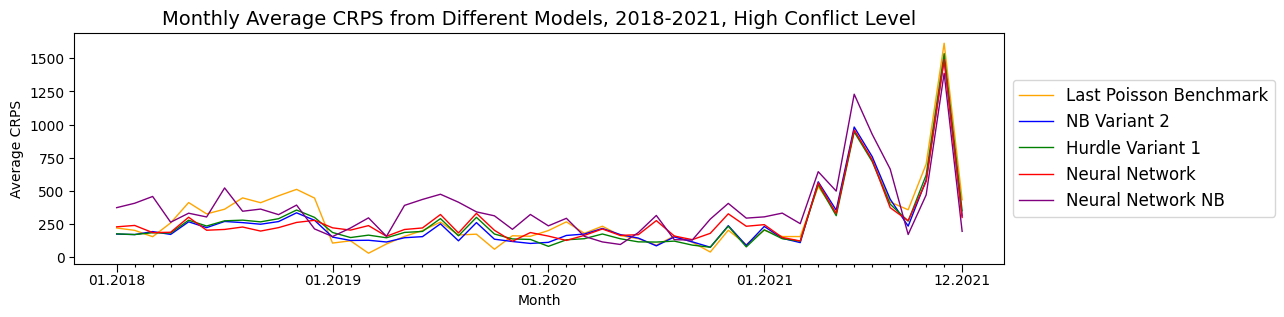

In [21]:
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import numpy as np

conflict_level = 'high'

months = month_list_plot

last_poisson = crps_conflict_level[conflict_level]['pois']
nb_baseline = crps_conflict_level[conflict_level]['NB']
hurdle_baseline = crps_conflict_level[conflict_level]['Hurdle']
nn = crps_conflict_level[conflict_level]['NN']
nn_negbin = crps_conflict_level[conflict_level]['NN_NegBin']

plt.figure(figsize=(12, 3))

# Erzeuge das Liniendiagramm
plt.plot(months, last_poisson, color='orange', linewidth=1, label='Last Poisson Benchmark')
plt.plot(months, nb_baseline, color='blue', linewidth=1, label='NB Variant 2')
plt.plot(months, hurdle_baseline, color='green', linewidth=1, label='Hurdle Variant 1')
plt.plot(months, nn, linewidth=1, color='red', label='Neural Network')
plt.plot(months, nn_negbin, linewidth=1, color='purple', label='Neural Network NB')

custom_ticks = months
custom_labels = []
january = ['01.2018','01.2019','01.2020','01.2021','12.2021']
january_list = [0,12,24,36,47]
j = 0
for i in range(len(months)):
    if i in january_list: 
        custom_labels.append(january[j])
        j += 1
    else:
        custom_labels.append('')

plt.xticks(custom_ticks, custom_labels)

# Mache bestimmte Ticks dicker
for i, tick in enumerate(plt.gca().xaxis.get_major_ticks()):
    if i in january_list:
        #tick.label1.set_fontsize(14)  # Setze die Dicke der gewünschten Ticks
        tick.tick1line.set_markersize(6)  # Ändert die Länge der Ticks
        tick.label1.set_verticalalignment('top')
    else:
        tick.tick1line.set_markersize(2) 

plt.title('Monthly Average CRPS from Different Models, 2018-2021, ' + 'High' + ' Conflict Level', fontsize=14, y=1)
plt.xlabel('Month')
plt.ylabel('Average CRPS')

# Fasse die Quantile zu einem Eintrag in der Legende zusammen und platziere sie rechts
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=12)

# Zeige das Diagramm
plt.show()

# Geomap Performance of the different models throughout the test window years 

In [22]:
import CRPS.CRPS as pscore
import warnings

warnings.filterwarnings("ignore")

s_prediction_list = list(range(3, 15))

data = {'country_id': [], 'best_model': []}
df_best_model_dict = {'2018':pd.DataFrame(data),'2019':pd.DataFrame(data),'2020':pd.DataFrame(data),'2021':pd.DataFrame(data)}
keys_list = list(df_best_model_dict.keys())

model_list = ['Pois. Bench.', 'NB', 'Hurdle', 'Neural Net', 'Neural Net NB']
iso_2_codes_list = ['GY', 'SR', 'TT', 'VE', 'WS', 'TO', 'AR', 'BO', 'BR', 'CL', 'EC', 'PY', 'PE', 'UY', 'GT', 'MX', 'BB', 'DM', 'GD', 'LC', 'VC', 'DO', 'HT', 'JM', 'BS', 'BZ', 'CO', 'CR', 'CU', 'SV', 'HN', 'NI', 'PA', 'AG', 'KN', 'IS', 'IE', 'GB', 'CV', 'CI', 'GH', 'LR', 'PT', 'ES', 'BF', 'GN', 'GW', 'ML', 'SN', 'SL', 'GM', 'DJ', 'ER', 'ET', 'MN', 'IQ', 'JO', 'KZ', 'NO', 'RU', 'SE', 'DZ', 'CM', 'CF', 'TN', 'BJ', 'GQ', 'KI', 'NE', 'NG', 'ST', 'TG', 'AL', 'BA', 'HR', 'IT', 'MK', 'MT', 'BG', 'CY', 'GE', 'GR', 'LB', 'TR', 'AT', 'CZ', 'DK', 'HU', 'PL', 'SK', 'SI', 'BE', 'FR', 'LU', 'NL', 'CH', 'BY', 'EE', 'FI', 'LV', 'LT', 'MD', 'RO', 'UA', 'MV', 'OM', 'SO', 'LK', 'TM', 'UZ', 'YE', 'AM', 'AZ', 'BH', 'IR', 'KW', 'QA', 'SA', 'AE', 'AF', 'KG', 'NP', 'PK', 'TJ', 'BD', 'BT', 'BN', 'JP', 'KP', 'PW', 'PH', 'KR', 'KH', 'LA', 'MM', 'TH', 'VN', 'MH', 'FM', 'BW', 'BI', 'RW', 'ZM', 'ZW', 'KM', 'LS', 'MW', 'MZ', 'ZA', 'SZ', 'AO', 'CG', 'CD', 'FJ', 'GA', 'NA', 'NZ', 'MG', 'MU', 'SC', 'TL', 'AU', 'NR', 'PG', 'SB', 'TV', 'VU', 'CA', 'DE', 'TW', 'CN', 'MY', 'SG', 'ID', 'LY', 'TD', 'IL', 'SY', 'EG', 'IN', 'ME', 'XK', 'RS', 'US', 'UG', 'KE', 'TZ', 'MA', 'MR', 'SD', 'SS']


for i in range(len(actual_years)): 
    year = actual_years[i]   
    dataset_index = actual_years.index(year)

    last_poisson_data = prediction_data_list[dataset_index]['benchmark']
    nb_baseline_data = prediction_data_list[dataset_index]['NB']
    hurdle_baseline_data = prediction_data_list[dataset_index]['Hurdle']
    nn_data = prediction_data_list[dataset_index]['NN']
    nn_negbin_data = prediction_data_list[dataset_index]['NNNegBin']

    actual_data = actuals_df_list[dataset_index]['data']
    actual_group = actual_data.groupby('country_id')

    for country in country_list:
        
        mean_crps_last_poisson = []
        mean_crps_nb_baseline = []
        mean_crps_hurdle_baseline = []
        mean_crps_nn_empirical = []
        mean_crps_nn_negbin = []

        
        for s in s_prediction_list:
            prediction_month = actual_data.index.get_level_values('month_id').unique().to_list()[s-3]
            y_true = actual_group.get_group(country).iloc[s-3,0]
            
            last_poisson_empirical_distribution = last_poisson_data.loc[(prediction_month,country),:].values.flatten()
            nb_baseline_empirical_distribution = nb_baseline_data.loc[(prediction_month,country),:].values.flatten()
            hurdle_baseline_empirical_distribution = hurdle_baseline_data.loc[(prediction_month,country),:].values.flatten()
            nn_empirical_distribution = nn_data.loc[(prediction_month,country),:].values.flatten()
            nn_negbin_empirical_distribution = nn_negbin_data.loc[(prediction_month,country),:].values.flatten()

            mean_crps_last_poisson.append(pscore(last_poisson_empirical_distribution,y_true).compute()[0])
            mean_crps_nb_baseline.append(pscore(nb_baseline_empirical_distribution,y_true).compute()[0])
            mean_crps_hurdle_baseline.append(pscore(hurdle_baseline_empirical_distribution,y_true).compute()[0])
            mean_crps_nn_empirical.append(pscore(nn_empirical_distribution,y_true).compute()[0])
            mean_crps_nn_negbin.append(pscore(nn_negbin_empirical_distribution,y_true).compute()[0])

        crps_poisson = np.mean(mean_crps_last_poisson)
        crps_nb = np.mean(mean_crps_nb_baseline)
        crps_hurdle = np.mean(mean_crps_hurdle_baseline)
        crps_nn = np.mean(mean_crps_nn_empirical)
        crps_nn_negbin = np.mean(mean_crps_nn_negbin)


        # Liste der Variablen
        variables = [crps_poisson, crps_nb, crps_hurdle, crps_nn, crps_nn_negbin]

        # Initialisieren der Variable mit dem minimalen Wert
        min_var = np.min(variables)

        model_string = ''

        if all(var == variables[0] for var in variables):
            model_string = 'No Preferred Model'
        else:
            # Schleife zur Überprüfung
            for j in range(len(variables)):
                var = variables[j]
                if var == min_var:
                    model_string = model_list[j]

        df_best_model_dict[keys_list[i]].loc[len(df_best_model_dict[keys_list[i]])] = [country, model_string]
    df_best_model_dict[keys_list[i]]['code'] = iso_2_codes_list

In [23]:
import geopandas as gpd
import pandas as pd
import math
import numpy as np
import matplotlib.pyplot as plt
import os
import country_converter as coco

relative_path_shapefile = os.path.join('..', 'plots_model_comp','ne_10m_admin_0_countries', 'ne_10m_admin_0_countries.shp')
SHAPEFILE = os.path.join(current_dir, relative_path_shapefile)


# Read shapefile using Geopandas
geo_df = gpd.read_file(SHAPEFILE)[['ADMIN', 'ADM0_A3', 'geometry']]

# Rename columns.
geo_df.columns = ['country', 'country_code', 'geometry']
geo_df.head(3)

# Drop row for 'Antarctica'. It takes a lot of space in the map and is not of much use
geo_df = geo_df.drop(geo_df.loc[geo_df['country'] == 'Antarctica'].index)

# Next, we need to ensure that our data matches with the country codes. 
iso3_codes = geo_df['country'].to_list()
# Convert to iso3_codes
iso2_codes_list = coco.convert(names=iso3_codes, to='ISO2', not_found='NULL')
# Add the list with iso2 codes to the dataframe
geo_df['iso2_code'] = iso2_codes_list
# There are some countries for which the converter could not find a country code. 
# We will drop these countries.
geo_df = geo_df.drop(geo_df.loc[geo_df['iso2_code'] == 'NULL'].index)


Dhekelia Sovereign Base Area not found in regex
US Naval Base Guantanamo Bay not found in regex
Siachen Glacier not found in regex
Baykonur Cosmodrome not found in regex
Akrotiri Sovereign Base Area not found in regex
Southern Patagonian Ice Field not found in regex
Bir Tawil not found in regex
Indian Ocean Territories not found in regex
Coral Sea Islands not found in regex
Spratly Islands not found in regex
Clipperton Island not found in regex
Ashmore and Cartier Islands not found in regex
Bajo Nuevo Bank (Petrel Is.) not found in regex
Serranilla Bank not found in regex
Scarborough Reef not found in regex


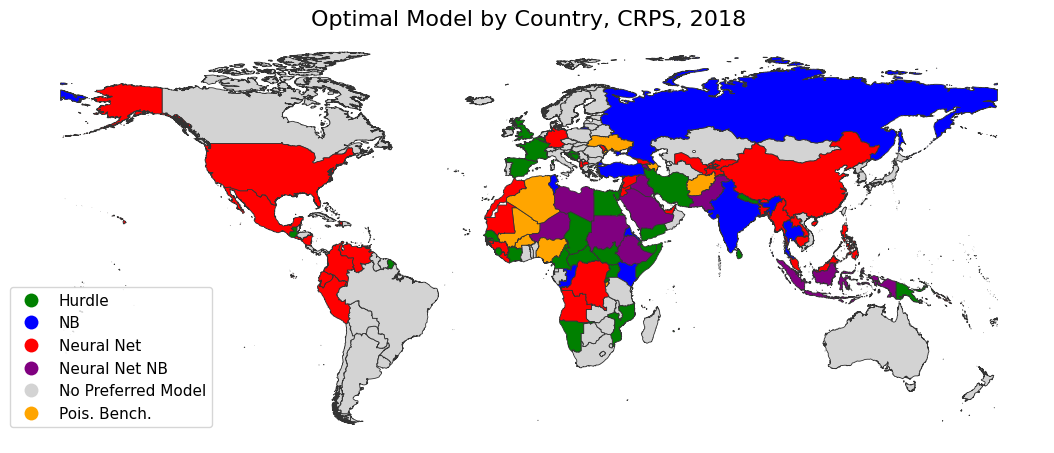

In [43]:
import pandas as pd
import geopandas as gpd
import json
import matplotlib as mpl
import pylab as plt
import matplotlib.colors as mcolors

merged_df_18 = pd.merge(left=geo_df, right=df_best_model_dict['2018'], how='right', left_on='iso2_code', right_on='code')
df = merged_df_18.drop(['code'], axis=1)

colors = ['green','blue','red','purple','lightgrey', 'orange']

cmap = mcolors.ListedColormap(colors)

fig, ax = plt.subplots(1, figsize=(11,7))
df.plot(column='best_model', categorical=True, cmap=cmap, linewidth=.6, edgecolor='0.2',
         legend=True, legend_kwds={'bbox_to_anchor':(.2, 0.4),'fontsize':11,'frameon':True}, ax=ax)

""" # Hier kommt die Anpassung der Legende
legend = ax.get_legend()
new_labels = ['Hurdle Variant 1', 'NB Variant 2', 'Neural Network', 'Neural Network NB', 'No Preferred Model', 'Last Poisson Benchmark']  # Ersetzen Sie diese mit Ihren eigenen Labels
for t, l in zip(legend.texts, new_labels):
    t.set_text(l) """

ax.axis('off')
ax.set_title('Optimal Model by Country, CRPS, 2018',fontsize=16)
plt.tight_layout()

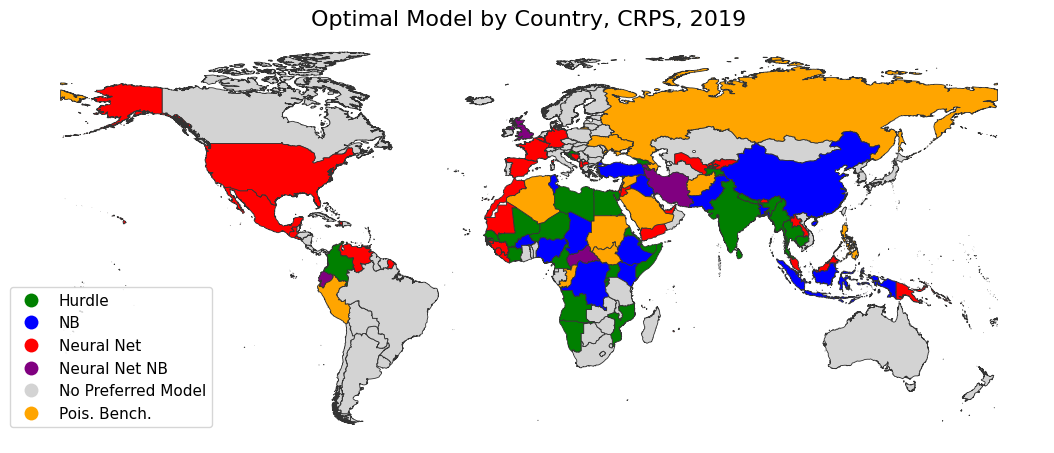

In [44]:
import pandas as pd
import geopandas as gpd
import json
import matplotlib as mpl
import pylab as plt
import matplotlib.colors as mcolors

merged_df_19 = pd.merge(left=geo_df, right=df_best_model_dict['2019'], how='right', left_on='iso2_code', right_on='code')
df = merged_df_19.drop(['code'], axis=1)

colors = ['green','blue','red','purple','lightgrey', 'orange']

cmap = mcolors.ListedColormap(colors)

fig, ax = plt.subplots(1, figsize=(11,7))
df.plot(column='best_model', categorical=True, cmap=cmap, linewidth=.6, edgecolor='0.2',
         legend=True, legend_kwds={'bbox_to_anchor':(.2, 0.4),'fontsize':11,'frameon':True}, ax=ax)
ax.axis('off')
ax.set_title('Optimal Model by Country, CRPS, 2019',fontsize=16)
plt.tight_layout()

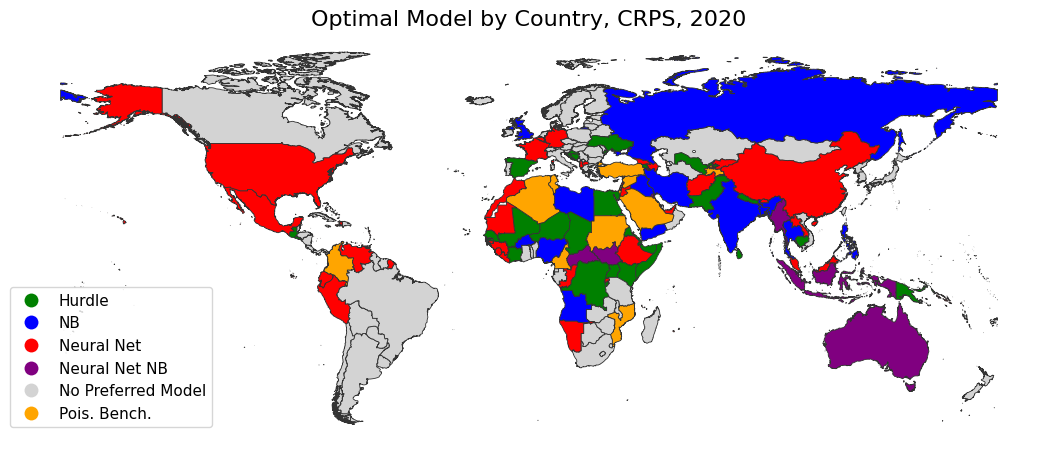

In [45]:
import pandas as pd
import geopandas as gpd
import json
import matplotlib as mpl
import pylab as plt
import matplotlib.colors as mcolors

merged_df_20 = pd.merge(left=geo_df, right=df_best_model_dict['2020'], how='right', left_on='iso2_code', right_on='code')
df = merged_df_20.drop(['code'], axis=1)

colors = ['green','blue','red','purple','lightgrey', 'orange']

cmap = mcolors.ListedColormap(colors)

fig, ax = plt.subplots(1, figsize=(11,7))
df.plot(column='best_model', categorical=True, cmap=cmap, linewidth=.6, edgecolor='0.2',
         legend=True, legend_kwds={'bbox_to_anchor':(.2, 0.4),'fontsize':11,'frameon':True}, ax=ax)
ax.axis('off')
ax.set_title('Optimal Model by Country, CRPS, 2020',fontsize=16)
plt.tight_layout()

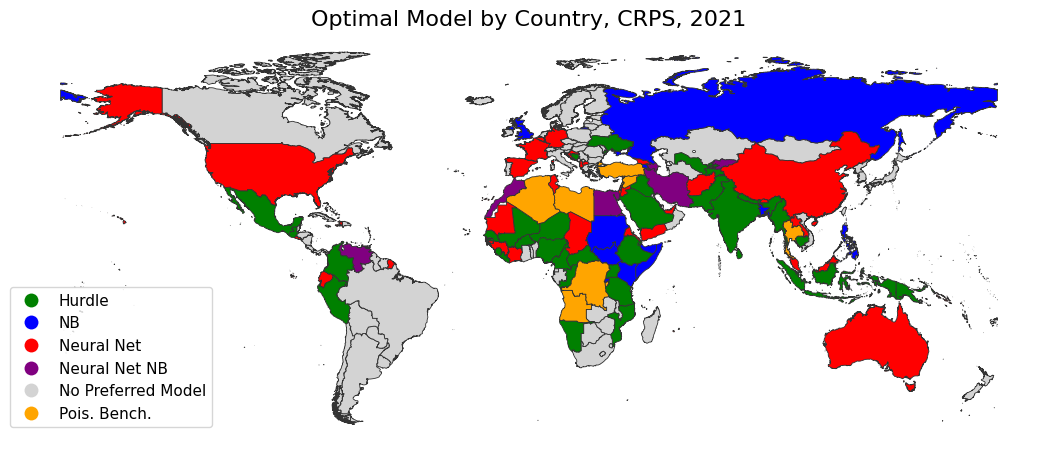

In [46]:
import pandas as pd
import geopandas as gpd
import json
import matplotlib as mpl
import pylab as plt
import matplotlib.colors as mcolors

merged_df_21 = pd.merge(left=geo_df, right=df_best_model_dict['2021'], how='right', left_on='iso2_code', right_on='code')
df = merged_df_21.drop(['code'], axis=1)

colors = ['green','blue','red','purple','lightgrey', 'orange']

cmap = mcolors.ListedColormap(colors)

fig, ax = plt.subplots(1, figsize=(11,7))
df.plot(column='best_model', categorical=True, cmap=cmap, linewidth=.6, edgecolor='0.2',
         legend=True, legend_kwds={'bbox_to_anchor':(.2, 0.4),'fontsize':11,'frameon':True}, ax=ax)
ax.axis('off')
ax.set_title('Optimal Model by Country, CRPS, 2021',fontsize=16)
plt.tight_layout()

# Average CRPS of the best performing model (NB) by Country for 2018-2021 

In [28]:
import CRPS.CRPS as pscore
import warnings

warnings.filterwarnings("ignore")

s_prediction_list = list(range(3, 15))

data = {'country_id': [], 'average_crps': []}
df_nb_average_crps = pd.DataFrame(data)

iso_2_codes_list = ['GY', 'SR', 'TT', 'VE', 'WS', 'TO', 'AR', 'BO', 'BR', 'CL', 'EC', 'PY', 'PE', 'UY', 'GT', 'MX', 'BB', 'DM', 'GD', 'LC', 'VC', 'DO', 'HT', 'JM', 'BS', 'BZ', 'CO', 'CR', 'CU', 'SV', 'HN', 'NI', 'PA', 'AG', 'KN', 'IS', 'IE', 'GB', 'CV', 'CI', 'GH', 'LR', 'PT', 'ES', 'BF', 'GN', 'GW', 'ML', 'SN', 'SL', 'GM', 'DJ', 'ER', 'ET', 'MN', 'IQ', 'JO', 'KZ', 'NO', 'RU', 'SE', 'DZ', 'CM', 'CF', 'TN', 'BJ', 'GQ', 'KI', 'NE', 'NG', 'ST', 'TG', 'AL', 'BA', 'HR', 'IT', 'MK', 'MT', 'BG', 'CY', 'GE', 'GR', 'LB', 'TR', 'AT', 'CZ', 'DK', 'HU', 'PL', 'SK', 'SI', 'BE', 'FR', 'LU', 'NL', 'CH', 'BY', 'EE', 'FI', 'LV', 'LT', 'MD', 'RO', 'UA', 'MV', 'OM', 'SO', 'LK', 'TM', 'UZ', 'YE', 'AM', 'AZ', 'BH', 'IR', 'KW', 'QA', 'SA', 'AE', 'AF', 'KG', 'NP', 'PK', 'TJ', 'BD', 'BT', 'BN', 'JP', 'KP', 'PW', 'PH', 'KR', 'KH', 'LA', 'MM', 'TH', 'VN', 'MH', 'FM', 'BW', 'BI', 'RW', 'ZM', 'ZW', 'KM', 'LS', 'MW', 'MZ', 'ZA', 'SZ', 'AO', 'CG', 'CD', 'FJ', 'GA', 'NA', 'NZ', 'MG', 'MU', 'SC', 'TL', 'AU', 'NR', 'PG', 'SB', 'TV', 'VU', 'CA', 'DE', 'TW', 'CN', 'MY', 'SG', 'ID', 'LY', 'TD', 'IL', 'SY', 'EG', 'IN', 'ME', 'XK', 'RS', 'US', 'UG', 'KE', 'TZ', 'MA', 'MR', 'SD', 'SS']

for country in country_list:

    crps_nb_year = []

    for i in range(len(actual_years)): 
        
        year = actual_years[i]   
        dataset_index = actual_years.index(year)
        nb_baseline_data = prediction_data_list[dataset_index]['NB']

        actual_data = actuals_df_list[dataset_index]['data']
        actual_group = actual_data.groupby('country_id')

        mean_crps_nb = []

        for s in s_prediction_list:
            prediction_month = actual_data.index.get_level_values('month_id').unique().to_list()[s-3]
            y_true = actual_group.get_group(country).iloc[s-3,0]
            
            nb_baseline_empirical_distribution = nb_baseline_data.loc[(prediction_month,country),:].values.flatten()

            mean_crps_nb.append(pscore(nb_baseline_empirical_distribution,y_true).compute()[0])

        crps_nb_year.append(np.mean(mean_crps_nb))

    df_nb_average_crps.loc[len(df_nb_average_crps)] = [country, np.mean(crps_nb_year)]


df_nb_average_crps['code'] = iso_2_codes_list

[Text(1, 0.0, '0'),
 Text(1, 0.6020599913279624, '3'),
 Text(1, 1.0413926851582251, '10'),
 Text(1, 1.4913616938342726, '30'),
 Text(1, 2.0043213737826426, '100'),
 Text(1, 2.4785664955938436, '300'),
 Text(1, 2.963371449992853, '918')]

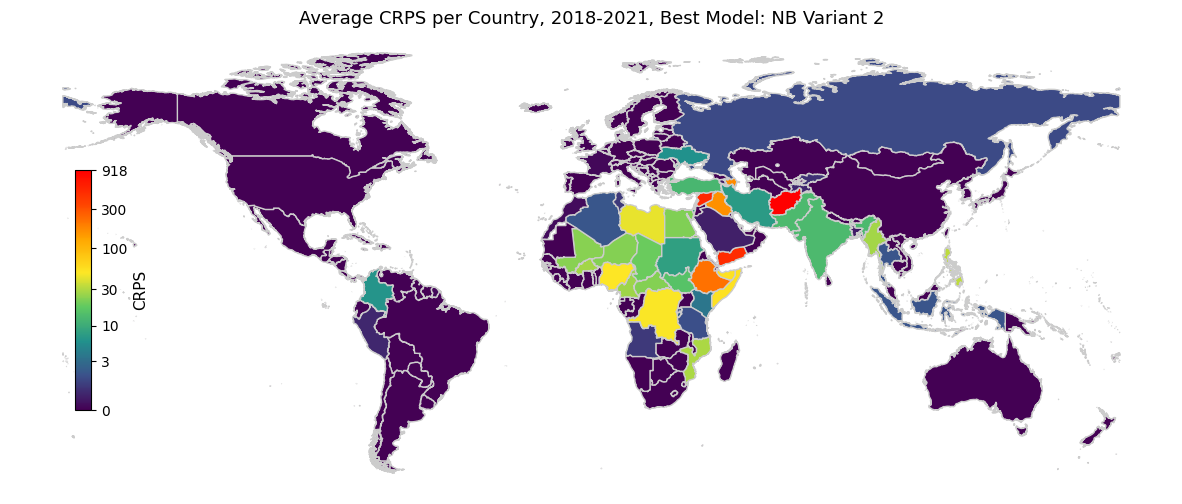

In [29]:
merged_df = pd.merge(left=geo_df, right=df_nb_average_crps, how='right', left_on='iso2_code', right_on='code')
df = merged_df.drop(['code'], axis=1)

# Print the map
# Set the range for the choropleth
from numpy import log10
import matplotlib.colors as mcolors

title = 'Average CRPS per Country, 2018-2021, Best Model: NB Variant 2'

df['log10_average_crps'] = log10(df['average_crps']+1)

col = 'log10_average_crps'
vmin = df[col].min()
vmax = df[col].max()

colors = ['#440154', '#3b528b', '#21918c', '#5ec962', '#fde725', '#FFA500', '#FF4500', '#FF0000']

cmap = mcolors.LinearSegmentedColormap.from_list('custom', colors)
# Create figure and axes for Matplotlib
fig, ax = plt.subplots(1, figsize=(16, 6))
# Remove the axis
ax.axis('off')
df.plot(column=col, ax=ax, edgecolor='0.8', linewidth=1, cmap=cmap)
# Add a title
ax.set_title(title, fontdict={'fontsize': '13', 'fontweight': '2'})
# Create an annotation for the data source
            
# Create colorbar as a legend
sm = plt.cm.ScalarMappable(norm=plt.Normalize(vmin=vmin, vmax=vmax), cmap=cmap)
# Empty array for the data range
sm._A = []
# Add the colorbar to the figure
cbaxes = fig.add_axes([0.19, 0.25, 0.01, 0.4])

ticks = [log10(0 + 1), log10(3 + 1),log10(10 + 1),log10(30 + 1),log10(100 + 1),log10(300 + 1),vmax]

# Setzen Sie die Farbskala
cbar = fig.colorbar(sm, cax=cbaxes, ticks=ticks)
cbar.set_label('CRPS', fontsize=11)

# Überschreiben der Legendenbeschriftungen
new_labels = ['0', '3', '10', '30', '100','300', str(round(10**vmax - 1))]
cbar.ax.set_yticklabels(new_labels)

# Secondary metrics: Interval and ignorance score

In [30]:
import numpy as np
from collections import Counter

bins = [
        0,
        0.5,
        2.5,
        5.5,
        10.5,
        25.5,
        50.5,
        100.5,
        250.5,
        500.5,
        1000.5,
    ]

def _ensemble_ignorance_score(predictions, n, observed):
        c = Counter(predictions)
        # n = c.total() : this works from python version 3.10, avoid this for a while.
        prob = c[observed] / n # if counter[observed] is 0, then this returns correctly
        return -np.log2(prob)

def ensemble_ignorance_score(observations, forecasts, bins, low_bin = 0, high_bin = 10000):
    """
    This implements the Ensemble (Ranked) interval Score from the easyVerification R-package in Python. Also inspired by properscoring.crps_ensemble(),
    and has interface that works with the xskillscore package.

    Parameters
    ----------
    observations : float or array_like
        Observations float or array. Missing values (NaN) are given scores of
        NaN.
    forecasts : float or array_like
        Array of forecasts ensemble members, of the same shape as observations
        except for the axis along which RIGN is calculated (which should be the
        axis corresponding to the ensemble). If forecasts has the same shape as
        observations, the forecasts are treated as deterministic. Missing
        values (NaN) are ignored.
    round_values: converts input data to integers by rounding.
    

    Returns
    -------
    out : np.ndarray
        RIGN for each ensemble forecast against the observations.
    """
    observations = np.asarray(observations)
    forecasts = np.asarray(forecasts)

    assert np.all(forecasts >= 0), f"Forecasts must be non-negative."
    assert np.all(observations >= 0), f"Observations must be non-negative."

    assert isinstance(bins, (int, list)), f"bins must be an integer or a list with floats"
    if isinstance(bins, int):
        assert bins > 0, f"bins must be an integer above 0 or a list with floats."

    def digitize_minus_one(x, bins, right=False):
        return np.digitize(x, bins, right) - 1

    """ edges = np.histogram_bin_edges(forecasts[..., :], bins = bins, range = (low_bin, high_bin))
    binned_forecasts =  np.apply_along_axis(digitize_minus_one, axis = 1, arr = forecasts, bins = edges)
    binned_observations = digitize_minus_one(observations, edges) """

    edges = np.histogram_bin_edges(forecasts, bins=bins, range=(low_bin, high_bin))
    binned_forecasts = digitize_minus_one(forecasts, edges)
    binned_observations = digitize_minus_one(observations, edges)


    # Append one observation in each bin-category to the forecasts to prevent 0 probability occuring.
    unique_categories = np.arange(0, len(bins))
    binned_forecasts = np.concatenate((binned_forecasts, np.tile(unique_categories, binned_forecasts.shape[:-1] + (1,))), axis = -1)
    
    n = binned_forecasts.shape[-1]

    #if observations.shape == forecasts.shape:
        # exact prediction yields 0 ign
    ign_score = np.empty_like(binned_observations, dtype = float)
    for index in np.ndindex(ign_score.shape):
        ign_score[index] = _ensemble_ignorance_score(binned_forecasts[index], n, binned_observations[index])
    
    
    return ign_score

def interval_score(observed: np.array, predictions: np.array, prediction_interval_level: float = 0.90) -> np.array:
    """
    Interval Score implemented based on the scaled Mean Interval Score in the R tsRNN package https://rdrr.io/github/thfuchs/tsRNN/src/R/metrics_dist.R

    The Interval Score is a probabilistic prediction evaluation metric that weights between the narrowness of the forecast range and the ability to correctly hit the observed value within that interval.
    
    :param observed: observed values
    :type observed: array_like
    :param predictions: probabilistic predictions with the latter axis (-1) being the forecasts for each observed value
    :type predictions: array_like
    :param prediction_interval_level: prediction interval between [0, 1]
    :type prediction_interval_level: float
    :returns array_like with the interval score for each observed value
    :rtype array_like

    observed = np.random.negative_binomial(5, 0.8, size = 600)
    forecasts = np.random.negative_binomial(5, 0.8, size = (600, 1000))

    score = interval_score(observed, forecasts)
    print(f'MIS: {score.mean()}')

    """

    assert 0 < prediction_interval_level < 1, f"'prediction_interval_level' must be a number between 0 and 1." 

    alpha = 1 - prediction_interval_level
    lower = np.quantile(predictions, q = alpha/2, axis = -1)
    upper = np.quantile(predictions, q = 1 - (alpha/2), axis = -1)

    interval_width = upper - lower
    lower_coverage = (2/alpha)*(lower-observed) * (observed<lower)
    upper_coverage = (2/alpha)*(observed-upper) * (observed>upper)

    return(interval_width + lower_coverage + upper_coverage)

# Mean interval score for all models and test windows

In [31]:
import CRPS.CRPS as pscore

s_prediction_list = list(range(3, 15))

month_list_plot = []
ignorance_last_poisson = []
ignorance_nb_baseline = []
ignorance_hurdle_baseline = []
ignorance_nn = []
ignorance_nn_negbin = []

for year in actual_years:    
    dataset_index = actual_years.index(year)

    last_poisson_data = prediction_data_list[dataset_index]['benchmark']
    nb_baseline_data = prediction_data_list[dataset_index]['NB']
    hurdle_baseline_data = prediction_data_list[dataset_index]['Hurdle']
    nn_data = prediction_data_list[dataset_index]['NN']
    nn_negbin_data = prediction_data_list[dataset_index]['NNNegBin']

    actual_data = actuals_df_list[dataset_index]['data']
    actual_group = actual_data.groupby('country_id')

    for s in s_prediction_list:
        
        mean_ignorance_last_poisson = []
        mean_ignorance_nb_baseline = []
        mean_ignorance_hurdle_baseline = []
        mean_ignorance_nn_empirical = []
        mean_ignorance_nn_negbin = []

        for country in country_list:

            prediction_month = actual_data.index.get_level_values('month_id').unique().to_list()[s-3]
            y_true = actual_group.get_group(country).iloc[s-3,0]
            
            last_poisson_empirical_distribution = last_poisson_data.loc[(prediction_month,country),:].values.flatten()
            nb_baseline_empirical_distribution = nb_baseline_data.loc[(prediction_month,country),:].values.flatten()
            hurdle_baseline_empirical_distribution = hurdle_baseline_data.loc[(prediction_month,country),:].values.flatten()
            nn_empirical_distribution = nn_data.loc[(prediction_month,country),:].values.flatten()
            nn_negbin_empirical_distribution = nn_negbin_data.loc[(prediction_month,country),:].values.flatten()

            mean_ignorance_last_poisson.append(ensemble_ignorance_score(y_true, last_poisson_empirical_distribution, bins) + 0)
            mean_ignorance_nb_baseline.append(ensemble_ignorance_score(y_true, nb_baseline_empirical_distribution, bins) + 0)
            mean_ignorance_hurdle_baseline.append(ensemble_ignorance_score(y_true, hurdle_baseline_empirical_distribution, bins) + 0)
            mean_ignorance_nn_empirical.append(ensemble_ignorance_score(y_true, nn_empirical_distribution, bins) + 0)
            mean_ignorance_nn_negbin.append(ensemble_ignorance_score(y_true, nn_negbin_empirical_distribution, bins) + 0)

        month_list_plot.append(prediction_month)
        ignorance_last_poisson.append(np.mean(mean_ignorance_last_poisson))
        ignorance_nb_baseline.append(np.mean(mean_ignorance_nb_baseline))
        ignorance_hurdle_baseline.append(np.mean(mean_ignorance_hurdle_baseline))
        ignorance_nn.append(np.mean(mean_ignorance_nn_empirical))
        ignorance_nn_negbin.append(np.mean(mean_ignorance_nn_negbin))

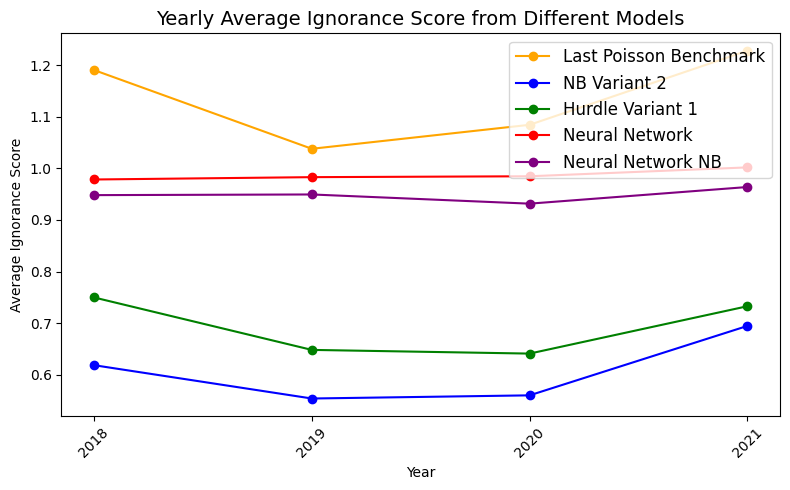

In [32]:
ignorance_by_year = {
    '2018': [],
    '2019': [],
    '2020': [],
    '2021': []
}

Keys_ignorance_by_year = list(ignorance_by_year.keys())
index_list = [[0,12], [12,24], [24,36], [36,48]]

for i in range(len(ignorance_by_year)):
    ignorance_by_year[Keys_ignorance_by_year[i]].append(np.mean(ignorance_last_poisson[index_list[i][0]:index_list[i][1]]))
    ignorance_by_year[Keys_ignorance_by_year[i]].append(np.mean(ignorance_nb_baseline[index_list[i][0]:index_list[i][1]]))
    ignorance_by_year[Keys_ignorance_by_year[i]].append(np.mean(ignorance_hurdle_baseline[index_list[i][0]:index_list[i][1]]))
    ignorance_by_year[Keys_ignorance_by_year[i]].append(np.mean(ignorance_nn[index_list[i][0]:index_list[i][1]]))
    ignorance_by_year[Keys_ignorance_by_year[i]].append(np.mean(ignorance_nn_negbin[index_list[i][0]:index_list[i][1]]))

import matplotlib.pyplot as plt

# Daten
methoden = [
    'Last Poisson Benchmark',
    'NB Variant 2',
    'Hurdle Variant 1',
    'Neural Network',
    'Neural Network NB'
]

# Plot erstellen
plt.figure(figsize=(8, 5))

colors = ['orange','blue','green','red','purple']

# Für jede Methode eine Linie zeichnen
for i, methode in enumerate(methoden):
    plt.plot(ignorance_by_year.keys(), [ignorance_by_year[jahr][i] for jahr in ignorance_by_year.keys()], marker='o', label=methode, color=colors[i])

# Titel und Achsenbeschriftungen
plt.title('Yearly Average Ignorance Score from Different Models', fontsize=14)
plt.xlabel('Year')
plt.ylabel('Average Ignorance Score')

# Legende hinzufügen
plt.legend(fontsize=12, loc='upper right') #loc='center left', bbox_to_anchor=(1, 0.5)

# Diagramm anzeigen
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [33]:
ignorance_by_year['2021']

[1.2276841817100899,
 0.6947619168987309,
 0.7329294228216651,
 1.0017853229529017,
 0.963759255333344]

# Mean interval score for all models and test windows

In [34]:
import CRPS.CRPS as pscore

s_prediction_list = list(range(3, 15))

month_list_plot = []
interval_last_poisson = []
interval_nb_baseline = []
interval_hurdle_baseline = []
interval_nn = []
interval_nn_negbin = []

for year in actual_years:    
    dataset_index = actual_years.index(year)

    last_poisson_data = prediction_data_list[dataset_index]['benchmark']
    nb_baseline_data = prediction_data_list[dataset_index]['NB']
    hurdle_baseline_data = prediction_data_list[dataset_index]['Hurdle']
    nn_data = prediction_data_list[dataset_index]['NN']
    nn_negbin_data = prediction_data_list[dataset_index]['NNNegBin']

    actual_data = actuals_df_list[dataset_index]['data']
    actual_group = actual_data.groupby('country_id')

    for s in s_prediction_list:
        
        mean_interval_last_poisson = []
        mean_interval_nb_baseline = []
        mean_interval_hurdle_baseline = []
        mean_interval_nn_empirical = []
        mean_interval_nn_negbin = []

        for country in country_list:

            prediction_month = actual_data.index.get_level_values('month_id').unique().to_list()[s-3]
            y_true = actual_group.get_group(country).iloc[s-3,0]
            
            last_poisson_empirical_distribution = last_poisson_data.loc[(prediction_month,country),:].values.flatten()
            nb_baseline_empirical_distribution = nb_baseline_data.loc[(prediction_month,country),:].values.flatten()
            hurdle_baseline_empirical_distribution = hurdle_baseline_data.loc[(prediction_month,country),:].values.flatten()
            nn_empirical_distribution = nn_data.loc[(prediction_month,country),:].values.flatten()
            nn_negbin_empirical_distribution = nn_negbin_data.loc[(prediction_month,country),:].values.flatten()

            mean_interval_last_poisson.append(interval_score(y_true, last_poisson_empirical_distribution))
            mean_interval_nb_baseline.append(interval_score(y_true, nb_baseline_empirical_distribution))
            mean_interval_hurdle_baseline.append(interval_score(y_true, hurdle_baseline_empirical_distribution))
            mean_interval_nn_empirical.append(interval_score(y_true, nn_empirical_distribution))
            mean_interval_nn_negbin.append(interval_score(y_true, nn_negbin_empirical_distribution))

        month_list_plot.append(prediction_month)
        interval_last_poisson.append(np.mean(mean_interval_last_poisson))
        interval_nb_baseline.append(np.mean(mean_interval_nb_baseline))
        interval_hurdle_baseline.append(np.mean(mean_interval_hurdle_baseline))
        interval_nn.append(np.mean(mean_interval_nn_empirical))
        interval_nn_negbin.append(np.mean(mean_interval_nn_negbin))

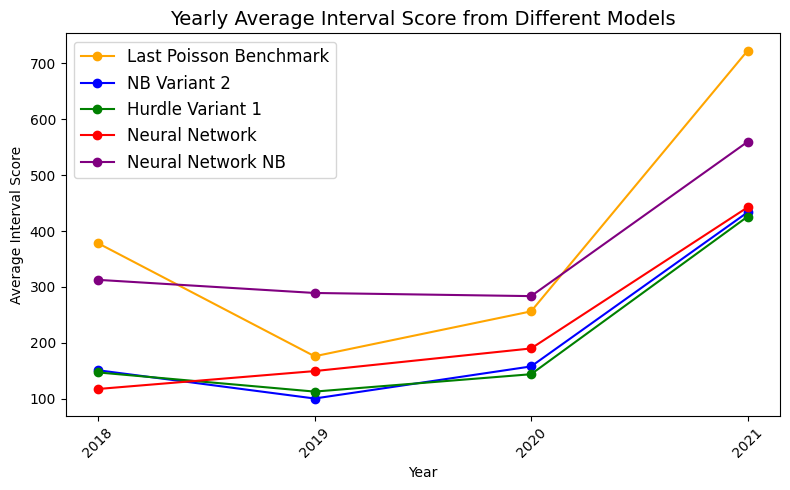

In [35]:
interval_by_year = {
    '2018': [],
    '2019': [],
    '2020': [],
    '2021': []
}

Keys_interval_by_year = list(interval_by_year.keys())
index_list = [[0,12], [12,24], [24,36], [36,48]]

for i in range(len(interval_by_year)):
    interval_by_year[Keys_interval_by_year[i]].append(np.mean(interval_last_poisson[index_list[i][0]:index_list[i][1]]))
    interval_by_year[Keys_interval_by_year[i]].append(np.mean(interval_nb_baseline[index_list[i][0]:index_list[i][1]]))
    interval_by_year[Keys_interval_by_year[i]].append(np.mean(interval_hurdle_baseline[index_list[i][0]:index_list[i][1]]))
    interval_by_year[Keys_interval_by_year[i]].append(np.mean(interval_nn[index_list[i][0]:index_list[i][1]]))
    interval_by_year[Keys_interval_by_year[i]].append(np.mean(interval_nn_negbin[index_list[i][0]:index_list[i][1]]))

import matplotlib.pyplot as plt

# Daten
methoden = [
    'Last Poisson Benchmark',
    'NB Variant 2',
    'Hurdle Variant 1',
    'Neural Network',
    'Neural Network NB'
]

# Plot erstellen
plt.figure(figsize=(8, 5))

colors = ['orange','blue','green','red','purple']

# Für jede Methode eine Linie zeichnen
for i, methode in enumerate(methoden):
    plt.plot(interval_by_year.keys(), [interval_by_year[jahr][i] for jahr in interval_by_year.keys()], marker='o', label=methode, color=colors[i])

# Titel und Achsenbeschriftungen
plt.title('Yearly Average Interval Score from Different Models', fontsize=14)
plt.xlabel('Year')
plt.ylabel('Average Interval Score')

# Legende hinzufügen
plt.legend(fontsize=12, loc='upper left') #loc='center left', bbox_to_anchor=(1, 0.5)

# Diagramm anzeigen
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [36]:
interval_by_year['2021']

[722.6736038394416,
 433.4547993019198,
 425.71343804537537,
 442.3282068062829,
 559.5847294938918]

# Geopandas map mean ignorance score NB Variant 2 2018-2021

In [37]:
s_prediction_list = list(range(3, 15))

data = {'country_id': [], 'average_ignorance': []}
df_nb_average_ignorance = pd.DataFrame(data)

iso_2_codes_list = ['GY', 'SR', 'TT', 'VE', 'WS', 'TO', 'AR', 'BO', 'BR', 'CL', 'EC', 'PY', 'PE', 'UY', 'GT', 'MX', 'BB', 'DM', 'GD', 'LC', 'VC', 'DO', 'HT', 'JM', 'BS', 'BZ', 'CO', 'CR', 'CU', 'SV', 'HN', 'NI', 'PA', 'AG', 'KN', 'IS', 'IE', 'GB', 'CV', 'CI', 'GH', 'LR', 'PT', 'ES', 'BF', 'GN', 'GW', 'ML', 'SN', 'SL', 'GM', 'DJ', 'ER', 'ET', 'MN', 'IQ', 'JO', 'KZ', 'NO', 'RU', 'SE', 'DZ', 'CM', 'CF', 'TN', 'BJ', 'GQ', 'KI', 'NE', 'NG', 'ST', 'TG', 'AL', 'BA', 'HR', 'IT', 'MK', 'MT', 'BG', 'CY', 'GE', 'GR', 'LB', 'TR', 'AT', 'CZ', 'DK', 'HU', 'PL', 'SK', 'SI', 'BE', 'FR', 'LU', 'NL', 'CH', 'BY', 'EE', 'FI', 'LV', 'LT', 'MD', 'RO', 'UA', 'MV', 'OM', 'SO', 'LK', 'TM', 'UZ', 'YE', 'AM', 'AZ', 'BH', 'IR', 'KW', 'QA', 'SA', 'AE', 'AF', 'KG', 'NP', 'PK', 'TJ', 'BD', 'BT', 'BN', 'JP', 'KP', 'PW', 'PH', 'KR', 'KH', 'LA', 'MM', 'TH', 'VN', 'MH', 'FM', 'BW', 'BI', 'RW', 'ZM', 'ZW', 'KM', 'LS', 'MW', 'MZ', 'ZA', 'SZ', 'AO', 'CG', 'CD', 'FJ', 'GA', 'NA', 'NZ', 'MG', 'MU', 'SC', 'TL', 'AU', 'NR', 'PG', 'SB', 'TV', 'VU', 'CA', 'DE', 'TW', 'CN', 'MY', 'SG', 'ID', 'LY', 'TD', 'IL', 'SY', 'EG', 'IN', 'ME', 'XK', 'RS', 'US', 'UG', 'KE', 'TZ', 'MA', 'MR', 'SD', 'SS']

for country in country_list:

    ignorance_nb_year = []

    for i in range(len(actual_years)): 
        
        year = actual_years[i]   
        dataset_index = actual_years.index(year)
        nb_baseline_data = prediction_data_list[dataset_index]['NB']

        actual_data = actuals_df_list[dataset_index]['data']
        actual_group = actual_data.groupby('country_id')

        mean_ignorance_nb = []

        for s in s_prediction_list:
            prediction_month = actual_data.index.get_level_values('month_id').unique().to_list()[s-3]
            y_true = actual_group.get_group(country).iloc[s-3,0]
            
            nb_baseline_empirical_distribution = nb_baseline_data.loc[(prediction_month,country),:].values.flatten()
            # hier einfach anderes modell einsetzen falls mean berechnet werden soll

            mean_ignorance_nb.append(ensemble_ignorance_score(y_true, nb_baseline_empirical_distribution, bins) + 0)

        ignorance_nb_year.append(np.mean(mean_ignorance_nb))

    df_nb_average_ignorance.loc[len(df_nb_average_ignorance)] = [country, np.mean(ignorance_nb_year)]


df_nb_average_ignorance['code'] = iso_2_codes_list

In [38]:
df_nb_average_ignorance

,country_id,average_ignorance,code
0,1.0,0.014355,GY
1,2.0,0.014355,SR
2,3.0,0.014355,TT
3,4.0,0.221976,VE
4,5.0,0.014355,WS
...,...,...,...
186,242.0,0.844662,TZ
187,243.0,0.637217,MA
188,244.0,0.014355,MR
189,245.0,2.666980,SD


In [39]:
np.mean(df_nb_average_ignorance['average_ignorance'])

0.6070594560663022

# Geopandas map mean interval score NB Variant 2 2018-2021

In [40]:
s_prediction_list = list(range(3, 15))

data = {'country_id': [], 'average_interval': []}
df_nb_average_interval = pd.DataFrame(data)

iso_2_codes_list = ['GY', 'SR', 'TT', 'VE', 'WS', 'TO', 'AR', 'BO', 'BR', 'CL', 'EC', 'PY', 'PE', 'UY', 'GT', 'MX', 'BB', 'DM', 'GD', 'LC', 'VC', 'DO', 'HT', 'JM', 'BS', 'BZ', 'CO', 'CR', 'CU', 'SV', 'HN', 'NI', 'PA', 'AG', 'KN', 'IS', 'IE', 'GB', 'CV', 'CI', 'GH', 'LR', 'PT', 'ES', 'BF', 'GN', 'GW', 'ML', 'SN', 'SL', 'GM', 'DJ', 'ER', 'ET', 'MN', 'IQ', 'JO', 'KZ', 'NO', 'RU', 'SE', 'DZ', 'CM', 'CF', 'TN', 'BJ', 'GQ', 'KI', 'NE', 'NG', 'ST', 'TG', 'AL', 'BA', 'HR', 'IT', 'MK', 'MT', 'BG', 'CY', 'GE', 'GR', 'LB', 'TR', 'AT', 'CZ', 'DK', 'HU', 'PL', 'SK', 'SI', 'BE', 'FR', 'LU', 'NL', 'CH', 'BY', 'EE', 'FI', 'LV', 'LT', 'MD', 'RO', 'UA', 'MV', 'OM', 'SO', 'LK', 'TM', 'UZ', 'YE', 'AM', 'AZ', 'BH', 'IR', 'KW', 'QA', 'SA', 'AE', 'AF', 'KG', 'NP', 'PK', 'TJ', 'BD', 'BT', 'BN', 'JP', 'KP', 'PW', 'PH', 'KR', 'KH', 'LA', 'MM', 'TH', 'VN', 'MH', 'FM', 'BW', 'BI', 'RW', 'ZM', 'ZW', 'KM', 'LS', 'MW', 'MZ', 'ZA', 'SZ', 'AO', 'CG', 'CD', 'FJ', 'GA', 'NA', 'NZ', 'MG', 'MU', 'SC', 'TL', 'AU', 'NR', 'PG', 'SB', 'TV', 'VU', 'CA', 'DE', 'TW', 'CN', 'MY', 'SG', 'ID', 'LY', 'TD', 'IL', 'SY', 'EG', 'IN', 'ME', 'XK', 'RS', 'US', 'UG', 'KE', 'TZ', 'MA', 'MR', 'SD', 'SS']

for country in country_list:

    interval_nb_year = []

    for i in range(len(actual_years)): 
        
        year = actual_years[i]   
        dataset_index = actual_years.index(year)
        nb_baseline_data = prediction_data_list[dataset_index]['NB']

        actual_data = actuals_df_list[dataset_index]['data']
        actual_group = actual_data.groupby('country_id')

        mean_interval_nb = []

        for s in s_prediction_list:
            prediction_month = actual_data.index.get_level_values('month_id').unique().to_list()[s-3]
            y_true = actual_group.get_group(country).iloc[s-3,0]
            
            nb_baseline_empirical_distribution = nb_baseline_data.loc[(prediction_month,country),:].values.flatten()

            mean_interval_nb.append(interval_score(y_true, nb_baseline_empirical_distribution))
            # hier einfach anderes modell einsetzen falls mean berechnet werden soll

        interval_nb_year.append(np.mean(mean_interval_nb))

    df_nb_average_interval.loc[len(df_nb_average_interval)] = [country, np.mean(interval_nb_year)]


df_nb_average_interval['code'] = iso_2_codes_list

In [41]:
np.mean(df_nb_average_interval['average_interval'])

210.53302792321122